# **Machine Learning Assignment Three**

Prepared By :
*   Taleen Abuzoluf  1211061
*   Mayar Jafar      1210582




---



## Choose a Learning Task

After inspecting the dataset, several possible learning tasks were considered. Image-based tasks were initially evaluated; however, many image links were found to be invalid or inaccessible, which introduced a high risk of missing or unusable data. As a result, image-based prediction tasks were excluded.

Instead, we focused on the textual descriptions, which were consistently available across the dataset. Based on this observation, predicting Mood/Emotion from the description was selected as the primary learning task. This task uses only the collected data and avoids issues related to broken image links.

Additionally, this task is challenging because the textual descriptions vary significantly in length and detail. Some entries contain long, expressive descriptions, while others are very short or vague. This variability increases the difficulty of learning consistent emotional patterns from text, making the task both non-trivial and suitable for deeper machine learning analysis.

### Code For Assembling Data in One CSV File  :

```python
import os
import pandas as pd
from io import StringIO

BASE = "compressed-attachments"
OUT  = "combined_clean.csv"

COLUMNS = [
    "Image URL","Description","Country","Weather",
    "Time of Day","Season","Activity","Mood/Emotion"
]

def decode_file(path):
    raw = open(path, "rb").read()

    # Skip ZIP or binary
    if raw[:2] == b"PK":
        return None

    for enc in ("utf-8", "cp1252", "latin1"):
        try:
            return raw.decode(enc)
        except:
            pass
    return None


def is_valid(row):
    if len(row) < 2:
        return False
    if not isinstance(row[0], str):
        return False
    if not row[0].startswith("http"):
        return False
    return True


import re

def extract_rows(path):
    try:
        text = decode_file(path)
        if text is None:
            return []

        good = []

        # Normal CSV attempt
        try:
            df = pd.read_csv(
                StringIO(text),
                header=None,
                quotechar='"',
                engine="python",
                on_bad_lines="skip"
            )

            for r in df.values.tolist():
                if is_valid(r):
                    r = r[:8]
                    while len(r) < 8:
                        r.append("")
                    good.append(r)

        except:
            pass

        # Deep recovery: find raw URLs
        if not good:
            lines = text.splitlines()
            for line in lines:
                if line.startswith("http"):
                    parts = list(pd.read_csv(StringIO(line), header=None).iloc[0])
                    if is_valid(parts):
                        parts = parts[:8]
                        while len(parts) < 8:
                            parts.append("")
                        good.append(parts)

        return good

    except:
        return []



rows = []

# ---- PER FOLDER: take best CSV ----
for folder in os.listdir(BASE):
    fpath = os.path.join(BASE, folder)
    if not os.path.isdir(fpath):
        continue

    best_rows = []
    best_file = None

    for file in os.listdir(fpath):
        if not file.lower().endswith(".csv"):
            continue

        path = os.path.join(fpath, file)
        extracted = extract_rows(path)

        if len(extracted) > len(best_rows):
            best_rows = extracted
            best_file = file

    if best_file:
        rows.extend(best_rows)
        print(f"✅ {folder}: {best_file} → {len(best_rows)} rows")
    else:
        print(f"❌ {folder}: no valid CSV")


# ---- FINAL CLEANING ----
final = pd.DataFrame(rows, columns=COLUMNS)
final = final.drop_duplicates()
final = final.dropna(subset=["Image URL","Description"], how="any")

final.to_csv(OUT, index=False)

print("\n FINAL RESULT")
print("Rows:", len(final))
print("Columns:", len(final.columns))
print("Saved to:", OUT)
```

The above code was used to collect and merge all CSV files located in each student’s folder into a single dataset. During this process, any file that caused a parsing error was identified and its filename was printed for inspection. These files were then individually reviewed and corrected. When issues could not be reliably resolved programmatically due to severe formatting inconsistencies or structural differences, the files were fixed manually to ensure accurate integration into the final dataset.

Imports:

In [ ]:
import pandas as pd

from google.colab import files
uploaded = files.upload()

Saving newfixed.csv to newfixed.csv


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sentence_transformers import SentenceTransformer
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report,confusion_matrix,ConfusionMatrixDisplay, f1_score
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.svm import SVC

target_col = "Mood/Emotion"

## Data Preprocessing and Exploratory Data Analysis (EDA)

---



### Data Preprocessing :

Read CSV:

In [ ]:
import pandas as pd

file_name = list(uploaded.keys())[0]

bad_lines = []

def bad_line_handler(line):
    bad_lines.append(line)
    return None

df = pd.read_csv(
    file_name,
    sep=",",
    quotechar='"',
    engine="python",
    on_bad_lines=bad_line_handler
)

print("Total rows loaded:", len(df))
print("Total bad lines:", len(bad_lines))


Total rows loaded: 1099
Total bad lines: 0


In [ ]:
with open(file_name, "r", encoding="utf-8") as f:
    raw_lines = f.readlines()

print("Physical lines in file:", len(raw_lines))



broken = []

for i, line in enumerate(raw_lines, start=1):
    if line.count('"') % 2 != 0:
        broken.append((i, line))

print("Lines with unclosed quotes:")
for b in broken[:10]:
    print(b)


Physical lines in file: 1100
Lines with unclosed quotes:


Show broken rows :

In [ ]:
if bad_lines:
    print("Bad lines detected:\n")
    for i, line in enumerate(bad_lines):
        print(f"Bad line {i+1}:")
        print(line)


Show Data structure :

In [ ]:
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1099 entries, 0 to 1098
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Image URL     1099 non-null   object
 1   Description   1099 non-null   object
 2   Country       1098 non-null   object
 3   Weather       1098 non-null   object
 4   Time of Day   1099 non-null   object
 5   Season        1099 non-null   object
 6   Activity      1067 non-null   object
 7   Mood/Emotion  1099 non-null   object
dtypes: object(8)
memory usage: 68.8+ KB


Missing values report:

In [ ]:
missing = df.isna().sum()
missing

,0
Image URL,0
Description,0
Country,1
Weather,1
Time of Day,0
Season,0
Activity,32
Mood/Emotion,0


Show rows that contain missing data

In [ ]:
df = df.applymap(lambda x: x.strip().lower() if isinstance(x,str) else x)
df.replace("", pd.NA, inplace=True)


/tmp/ipython-input-2579560513.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: x.strip().lower() if isinstance(x,str) else x)


### Handle Missing Values:

Address the missing values in the 'Country', 'Weather', and 'Activity' columns, considering appropriate imputation or removal strategies.


In [ ]:
df.loc[29, 'Country'] = 'switzerland'
df['Weather'] = df['Weather'].fillna('unknown')
df['Activity'] = df['Activity'].fillna('unknown')

print("Missing values after imputation:")
print(df.isna().sum())

Missing values after imputation:
Image URL       0
Description     0
Country         0
Weather         0
Time of Day     0
Season          0
Activity        0
Mood/Emotion    0
dtype: int64





### Standardize Categorical Data :

Further standardize categorical columns by inspecting unique values and correcting any inconsistencies or variations.


**Displaying all the unique values for each attribute**:

Here is all the unique values for each specified categorical column ('Country', 'Weather', 'Time of Day', 'Season', 'Activity', 'Mood/Emotion') to identify inconsistencies or variations that need standardization.



In [ ]:
categorical_cols = ['Country', 'Weather', 'Time of Day', 'Season', 'Activity', 'Mood/Emotion']

for col in categorical_cols:
    print(f"Unique values for '{col}':")
    print(df[col].unique())
    print("\n" + "-"*30 + "\n")

Unique values for 'Country':
['palestine' 'france' 'china' 'greece' 'usa' 'maldives' 'japan' 'peru'
 'canada' 'tanzania' 'australia' 'iceland' 'jordan' 'italy' 'austria'
 'brazil' 'vietnam' 'portugal' 'switzerland' 'turkey' 'nepal' 'egypt'
 'indonesia' 'south africa' 'spain' 'greenland' 'tunisia' 'syria'
 'morocco' 'london' 'germany' 'uae' 'paris' 'maldive' 'uk' 'netherlands'
 'czech republic' 'slovenia' 'chile' 'saudi arabia' 'india'
 'united kingdom' 'south korea' 'arctic circle' 'thailand' 'cambodia'
 'antarctica' 'united states' 'mecca' 'miami' 'jerusalem' 'new york'
 'california' 'french polynesia' 'norway' 'united arab emirates' 'eygypt'
 'mexico' 'russia' 'monaco' 'denmark' 'qatar' 'finland' 'myanmar'
 'new zealand' 'preu' 'rapa nui' 'hungary' 'wales' 'england' 'morroco'
 'bhutan' 'poland' 'andorra' 'cyprus' 'easter island' 'türkiye' 'korea'
 'kenya' 'united kingdom (scotland)' 'georgia' 'malta' 'lebanon'
 'hong kong' 'yemen' 'zimbabwe/zambia' 'tokyo/japan' 'singapore' 'algeria'

**Country Attribute**:

Based on the unique values observed, the 'Country' column contains various inconsistencies, including different spellings of the same country, cities listed as countries, and regions. I will standardize these values by mapping cities and regions to their respective countries and correcting common misspellings. This will involve creating a mapping dictionary and applying it to the 'Country' column.



In [ ]:
country_mapping = {
    'usa': 'united states',
    'united states of america': 'united states',
    'california, usa': 'united states',
    'miami': 'united states',
    'new york': 'united states',
    'california': 'united states',

    'uk': 'united kingdom',
    'united kingdom (scotland)': 'united kingdom',
    'scotland': 'united kingdom',
    'wales': 'united kingdom',
    'england': 'united kingdom',
    'london': 'united kingdom',

    'paris': 'france',
    'vienna': 'austria',
    'santorini': 'greece',
    'prague': 'czech republic',

    'tokyo/japan': 'japan',
    'interlaken': 'switzerland',
    'bali': 'indonesia',
    'holland': 'netherlands',
    'the netherlands': 'netherlands',

    'morroco': 'morocco',
    'eygypt': 'egypt',
    'egypt': 'egypt',
    'eygpt': 'egypt',
    'türkiye': 'turkey',
    'turkiye': 'turkey',
    'preu': 'peru',
    'maldive': 'maldives',
    'czechia': 'czech republic',
    'uae': 'united arab emirates',
    'united arab emirates': 'united arab emirates',
    'north pole, alaska': 'united states',
    'arctic circle': 'antarctica',
    'antarctica (continent, not a country)': 'antarctica',
    'suadi arabia': 'saudi arabia',
    'italy (lake como)': 'italy',
    'bali – indonesia.': 'indonesia',
    'jerusalem': 'palestine',
    'mecca': 'saudi arabia',
    'rapa nui': 'chile',
    'easter island': 'chile',
    'hong kong': 'china',
    'china and mongolia': 'unknown',
    'zimbabwe/zambia': 'unknown',
    'greenland': 'unknown',
    'french polynesia': 'unknown',
    'antarctica': 'unknown',

}

df['Country'] = df['Country'].replace(country_mapping)
#df['Country'] = df['Country'].apply(lambda x: x if x in country_mapping.values() or x not in country_mapping.keys() else 'unknown') # Map unlisted cities/regions to 'unknown' if not mapped above
df['Country'] = df['Country'].where(
    df['Country'].str.fullmatch(r"[a-z ]+"),
    'unknown'
)

print("Unique values for 'Country' after standardization:")
print(df['Country'].unique())
print("\n" + "-"*30 + "\n")

Unique values for 'Country' after standardization:
['palestine' 'france' 'china' 'greece' 'united states' 'maldives' 'japan'
 'peru' 'canada' 'tanzania' 'australia' 'iceland' 'jordan' 'italy'
 'austria' 'brazil' 'vietnam' 'portugal' 'switzerland' 'turkey' 'nepal'
 'egypt' 'indonesia' 'south africa' 'spain' 'unknown' 'tunisia' 'syria'
 'morocco' 'united kingdom' 'germany' 'united arab emirates' 'netherlands'
 'czech republic' 'slovenia' 'chile' 'saudi arabia' 'india' 'south korea'
 'antarctica' 'thailand' 'cambodia' 'norway' 'mexico' 'russia' 'monaco'
 'denmark' 'qatar' 'finland' 'myanmar' 'new zealand' 'hungary' 'bhutan'
 'poland' 'andorra' 'cyprus' 'korea' 'kenya' 'georgia' 'malta' 'lebanon'
 'yemen' 'singapore' 'algeria' 'zambia' 'oman' 'uzbekistan' 'seychelles'
 'sweden' 'malaysia' 'bosnia and herzegovina' 'kazakhstan' 'ireland'
 'albania' 'pakistan' 'croatia' 'bahamas' 'argentina' 'afghanistan'
 'philippines' 'bolivia' 'ukraine' 'costa rica' 'serbia' 'colombia'
 'taiwan' 'zimbabwe'

In [ ]:
print(len(df['Country'].unique()), "unique country values")
print(df['Country'].value_counts())


89 unique country values
Country
japan            71
italy            70
united states    61
france           60
switzerland      57
                 ..
colombia          1
taiwan            1
zimbabwe          1
romania           1
north korea       1
Name: count, Length: 89, dtype: int64


**Weather Attribute**:

Based on the identified inconsistencies in the unique values for the 'Weather' column, I will standardize them by creating a mapping dictionary to correct typos, merge similar categories, and simplify complex descriptions.



In [ ]:
weather_classes = {
    'Not Clear': [
        'cold', 'windy', 'not clear', 'no clear', 'not clear (night lighting)',
        'clear night', 'unknown', 'foggy', 'misty'
    ],
    'Sunny': [
        'sunny', 'clear', 'clear / sunny', 'clear sky', 'bright', 'sunlight'
    ],
    'Rainy': [
        'rainy', 'raniy', 'showers', 'drizzle', 'rain'
    ],
    'Cloudy': [
        'cloudy', 'partly cloudy', 'cloudt', 'cloudy sunset', 'overcast'
    ],
    'Snowy': [
        'snowy', 'snow', 'snowing'
    ]
}

def map_weather_to_class(raw):
    if pd.isna(raw) or str(raw).strip() == "":
        return 'Not Clear'  # missing/empty

    parts = [p.strip().lower() for p in str(raw).split("/")]

    # Check Not Clear first
    for part in parts:
        if any(nc in part for nc in weather_classes['Not Clear']):
            return 'Not Clear'

    # Check other classes
    for cls, keywords in weather_classes.items():
        if cls == 'Not Clear':
            continue
        for part in parts:
            if any(kw in part for kw in keywords):
                return cls

    # Fallback
    return 'Not Clear'

df['Weather'] = df['Weather'].apply(map_weather_to_class)

print("Unique values for 'Weather' after standardization:")
print(df['Weather'].unique())


Unique values for 'Weather' after standardization:
['Sunny' 'Not Clear' 'Cloudy' 'Snowy' 'Rainy']


**Time of Day Attribute**:

Based on the previously observed unique values, the 'Time of Day' column contains minor inconsistencies like 'morning,' and descriptive variations like 'daytime' and 'not clear'. I will standardize these to a consistent set of categories by creating a mapping dictionary and applying it to the column.



In [ ]:
time_of_day_mapping = {
    'morning,': 'morning',
    'daytime': 'morning',
    'afternoon': 'afternoon',
    'evening': 'evening',
    'night': 'evening',
    'noon': 'afternoon',
    'sunset': 'evening',
    'sunrise': 'morning',
    'not clear': 'unknown' # Map 'not clear' to 'unknown' for consistency
}

df['Time of Day'] = df['Time of Day'].replace(time_of_day_mapping)

print("Unique values for 'Time of Day' after standardization:")
print(df['Time of Day'].unique())
print("\n" + "-"*30 + "\n")

Unique values for 'Time of Day' after standardization:
['afternoon' 'morning' 'evening' 'unknown']

------------------------------



**Season Attribute**:

Based on the identified inconsistencies in the unique values for the 'Season' column, I will standardize them by creating a mapping dictionary to merge similar categories and address ambiguous entries.



In [ ]:
season_mapping = {
    'not clear': 'unknown',
    'clear': 'unknown',
    'autumn': 'fall'
}

df['Season'] = df['Season'].replace(season_mapping)

print("Unique values for 'Season' after standardization:")
print(df['Season'].unique())
print("\n" + "-"*30 + "\n")

Unique values for 'Season' after standardization:
['summer' 'spring' 'unknown' 'winter' 'fall']

------------------------------



**Activity Attribute**:

Based on the unique values for the 'Activity' column observed previously, there are many variations, synonyms, and descriptive phrases that represent similar activities. I will standardize these values by creating a comprehensive mapping dictionary to group similar activities under a common, more concise category.



In [ ]:
activity_mapping = {
    'sightseeing': [ 'sightseeing','sightseein', 'sightseing', 'siteseeking', 'city sightseeing',
        'sightseeing/ hiking', 'sightseeing and relaxing on the grass',
        'sightseeing / river cruising', 'historical sightseeing',
        'nature sightseeing', 'countryside sightseeing','stargazing', 'aurora watching', 'mountain viewing','tourism','city walking / sightseeing','spectating' ,'wildlife watching'
    ],
    'exploring': ['exploring','village exploring', 'city nightlife exploring', 'urban exploration', 'city exploring', 'urban exploring','city tour','nature exploring'],
    'hiking': ['hiking','hiking / sightseeing', 'hiking / exploring', 'hiking and exploring nature', 'hiking in the mountains','hiking / exploring ruins'],
    'relaxing': ['relaxing / sightseeing', 'relaxing / nature viewing', 'relaxing','urban life','nature watching','nature viewing','meditation','resort stay','vacationing'],
    'water activities': ['swimming', 'snorkeling', 'snorkelling', 'diving', 'sailing', 'canoeing', 'boat ride', 'boat tour', 'boating', 'gondola riding', 'boat riding','beachgoing', 'boat riding / sightseeing', 'boat riding / swimming / sightseeing','rowing', 'canal touring', 'walking in the canal'],
    'walking': ['walking', 'city walk', 'walking / city exploring', 'strolling'],
    'sports': ['sports', 'football', 'stadium tour', 'sports event', 'bungee jumping', 'skiing','hot air ballooning', 'skydiving', 'cliff jumping', 'jet skiing', 'surfing', 'snow activities','boarding', 'ice skating', 'skating' ,'cycling','safari','scuba diving','watching a football match'],
    'cultural experience': ['cultural experience', 'festival participation','history tour','celebration', 'eating', 'breakfast in front of al-aqsa mosque'],
    'transportation/visiting': ['touring', 'visiting' , 'walking', 'city walk', 'walking / city exploring', 'strolling', 'walking / village exploring', 'walking / commuting / sightseeing', 'walking / photography','nature walk', 'walking tour', 'walking around the city', 'city strolling', 'city stroll'],
    'riding': ['horse riding', 'camel riding', 'riding'],
    'worship/pilgrimage': ['worship', 'pilgrimage', 'praying', 'religious worship', 'religious visit', 'pilgrimage / spiritual visit', 'religious/spiritual visit'],

}

# Flatten keywords for faster lookup
keyword_to_class = {}
for cls, keywords in activity_mapping.items():
    for kw in keywords:
        keyword_to_class[kw.strip().lower()] = cls

def map_activity_keep_original(act):
    if pd.isna(act) or str(act).strip() == "":
        return 'unknown'  # only for missing/null

    act_lower = str(act).lower().strip()

    # check if any keyword is in the activity text
    for kw, cls in keyword_to_class.items():
        if kw in act_lower:
            return cls  # map to the predefined class

    return act.strip()  # keep original if no match

# Apply mapping
df['Activity'] = df['Activity'].apply(map_activity_keep_original)

# Print unique activities after mapping
print("Unique values for 'Activity' after mapping (no 'other'):")
print(df['Activity'].unique())
print(df['Activity'].value_counts())

#df['Activity'] = df['Activity'].apply(map_activity_to_class)
# print("Unique values for 'Activity' after standardization:")
# print(df['Activity'].unique())
print("\n" + "-"*30 + "\n")

Unique values for 'Activity' after mapping (no 'other'):
['sightseeing' 'exploring' 'hiking' 'relaxing' 'water activities'
 'no activity' 'shopping' 'hot-air balloon ride' 'riding'
 'transportation/visiting' 'viewing nature / countryside' 'sports'
 'photography' 'worship/pilgrimage' 'traditional shopping' 'unknown'
 'cultural experience' 'cultural exploration' 'cultural visit' 'camping'
 'nature exploration' 'gaming and entertainment' 'ballooning' 'vacation'
 'city exploration' 'biking' 'entertainment' 'traveling' 'cultural tour'
 'wandering' 'romance']
Activity
sightseeing                     561
relaxing                        173
hiking                          103
exploring                        43
worship/pilgrimage               34
water activities                 32
unknown                          32
transportation/visiting          28
sports                           26
photography                       7
no activity                       7
cultural experience               7

Fixing more than one class label and the outliers

In [ ]:
print(df['Activity'].isna().sum())
print((df['Activity'] == "").sum())
df['Activity'].value_counts()
print(df['Activity'].unique())

0
0
['sightseeing' 'exploring' 'hiking' 'relaxing' 'water activities'
 'no activity' 'shopping' 'hot-air balloon ride' 'riding'
 'transportation/visiting' 'viewing nature / countryside' 'sports'
 'photography' 'worship/pilgrimage' 'traditional shopping' 'unknown'
 'cultural experience' 'cultural exploration' 'cultural visit' 'camping'
 'nature exploration' 'gaming and entertainment' 'ballooning' 'vacation'
 'city exploration' 'biking' 'entertainment' 'traveling' 'cultural tour'
 'wandering' 'romance']


In [ ]:
def semantic_activity_map(act):
    if pd.isna(act) or str(act).strip() == "":
        return "unknown"

    act = act.lower().strip()

    #  If it's already a valid class → keep it
    if act in activity_mapping:
        return act

    #  Try semantic matching for rare labels
    for cls, keywords in activity_mapping.items():
        for kw in keywords:
            if kw in act:
                return cls

    # 3️ Only true garbage becomes unknown
    return "unknown"



In [ ]:
df["Activity"] = df["Activity"].apply(semantic_activity_map)
df["Activity"].value_counts()


,count
Activity,
sightseeing,561
relaxing,173
hiking,103
unknown,87
exploring,43
worship/pilgrimage,34
water activities,32
transportation/visiting,28
sports,26


**Mood / Emotion Attribute**:

Based on the unique values observed for the 'Mood/Emotion' column, there are various inconsistencies, misspellings, and semantically similar entries. I will standardize these by creating a mapping dictionary to group them into more consistent categories and correct typos.



In [ ]:
# Original mapping
original_mood_groups = {
    'Excitement': ['awe', 'amazed', 'excitement', 'exitment', 'majestic', 'vibrant', 'magical', 'excitement / passion', 'awe and adventure', 'elegant', 'historic', 'spirituality','energy','impressed','inspiration'],
    'Happiness': ['relaxation', 'relaxed', 'calm', 'calmness', 'peaceful', 'tranquility', 'peace', 'serenity', 'joy', 'happiness', 'happiness.', 'humility','relaxing','peacefulness'],
    'Curiosity': ['curiosity', 'curiosty', 'curiousity', 'curosity', 'wonder', 'curiosity / awe', 'spiritual awe', 'sightseeing' ,'sight seeing'],
    'Nostalgia': ['nostalgia', 'reverence','respect' ,'reverence / awe'],
    'Adventure': ['adventure', 'advanture', 'adventurous'],
    'Romance': ['romance', 'romantic', 'romance.', 'romance .'],
    'Melancholy': ['melancholy']
}

# Build flat mapping
# Build flat mapping: map all terms to the 7 main classes
flat_mood_map = {}
for target_mood, source_list in original_mood_groups.items():
    for term in source_list:
        flat_mood_map[term.lower()] = target_mood
    flat_mood_map[target_mood.lower()] = target_mood  # include the class name itself

# Function to map moods, keep original if not in main classes, 'unknown' only for null
def map_mood_keep_original(m):
    if pd.isna(m) or str(m).strip() == "":
        return 'unknown'  # only for missing/null
    m_lower = str(m).strip().lower()
    return flat_mood_map.get(m_lower, m)  # map to main class or keep original

# Apply the function
df['Mood/Emotion'] = df['Mood/Emotion'].apply(map_mood_keep_original)


# Check final counts
print("Unique Mood/Emotion classes after mapping:")
print(df['Mood/Emotion'].value_counts())




Unique Mood/Emotion classes after mapping:
Mood/Emotion
Happiness     250
Adventure     205
Curiosity     204
Excitement    176
Romance       128
Nostalgia     117
Melancholy     19
Name: count, dtype: int64


Storing the cleaned and preprocessed data :

In [ ]:
df.to_csv('cleaned_data.csv', index=False)
print("Cleaned data saved to 'cleaned_data.csv'")

Cleaned data saved to 'cleaned_data.csv'


In [ ]:
df = pd.read_csv("cleaned_data.csv")

## **Exploratory Data Analysis:**


---



In this section, we analyze class distributions and relationships between categorical features using descriptive statistics, bar plots, and cross-tabulations to identify trends and potential challenges.

### Analyze Class Distributions of Categorical Features

Examine the unique values and their frequencies for all categorical columns to understand their individual distributions and identify any imbalances.


**Displaying all the classes / catrgories in each attribute**

To understand the distribution of each categorical feature, printed the specified columns and the frequency of each unique value using `value_counts()`.

In [ ]:
for col in categorical_cols:
    print(f"\nClass distribution for '{col}':")
    print(df[col].value_counts())
    print("\n" + "-"*50 + "\n")


Class distribution for 'Country':
Country
japan            71
italy            70
united states    61
france           60
switzerland      57
                 ..
colombia          1
taiwan            1
zimbabwe          1
romania           1
north korea       1
Name: count, Length: 89, dtype: int64

--------------------------------------------------


Class distribution for 'Weather':
Weather
Sunny        643
Cloudy       235
Not Clear    108
Snowy         90
Rainy         23
Name: count, dtype: int64

--------------------------------------------------


Class distribution for 'Time of Day':
Time of Day
afternoon    513
evening      312
morning      268
unknown        6
Name: count, dtype: int64

--------------------------------------------------


Class distribution for 'Season':
Season
summer     429
spring     219
winter     170
fall       153
unknown    128
Name: count, dtype: int64

--------------------------------------------------


Class distribution for 'Activity':
Activity
s

### Visualize Categorical Feature Distributions


Creating appropriate visualizations, such as bar plots, to graphically represent the class distributions of the categorical features for better understanding.


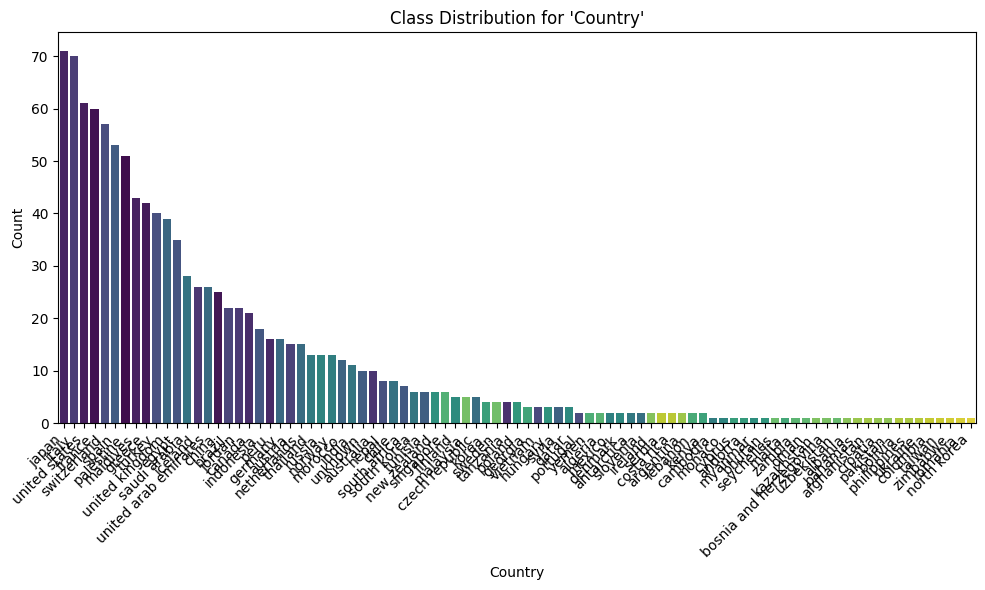

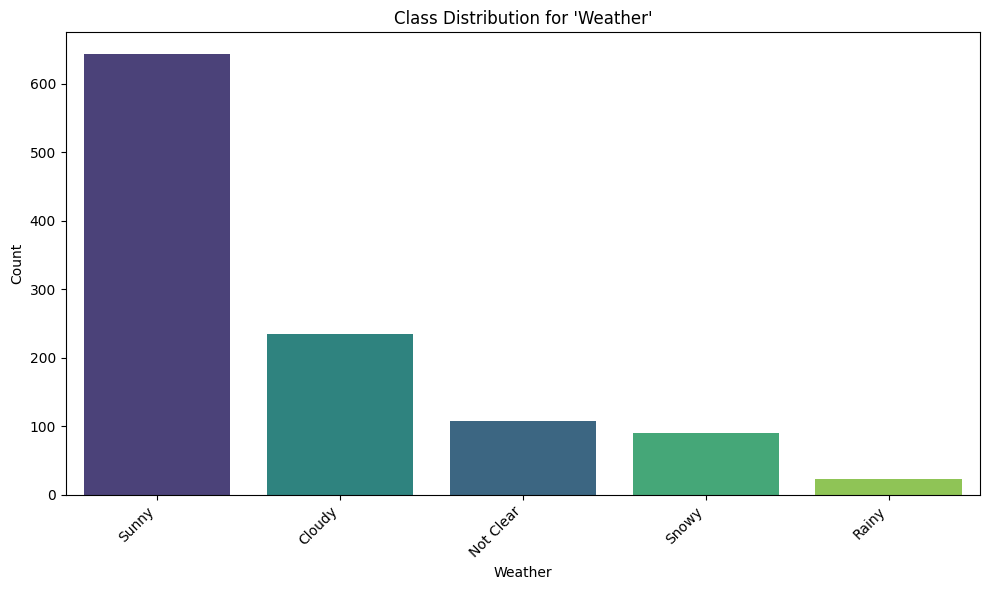

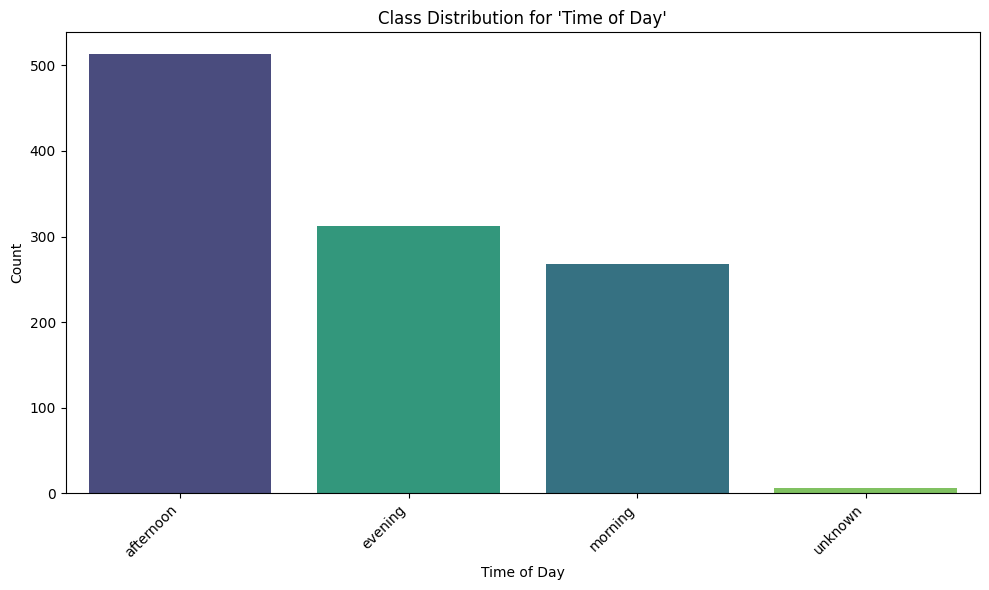

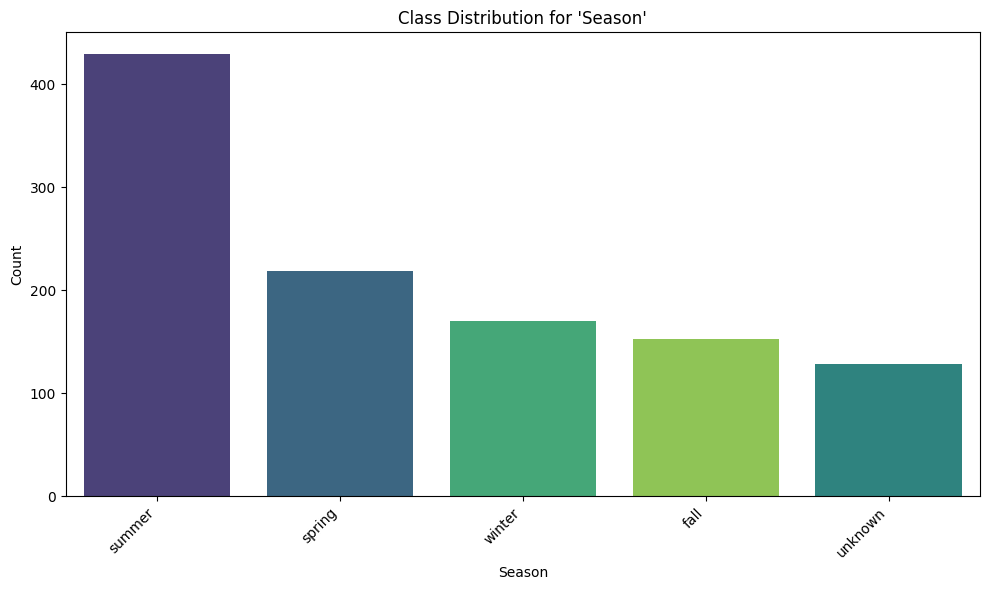

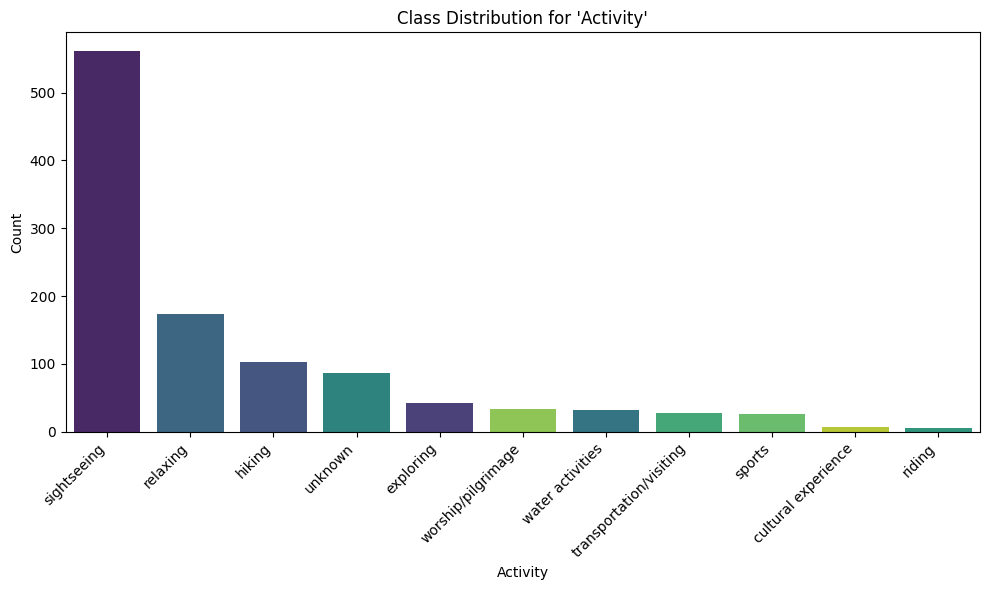

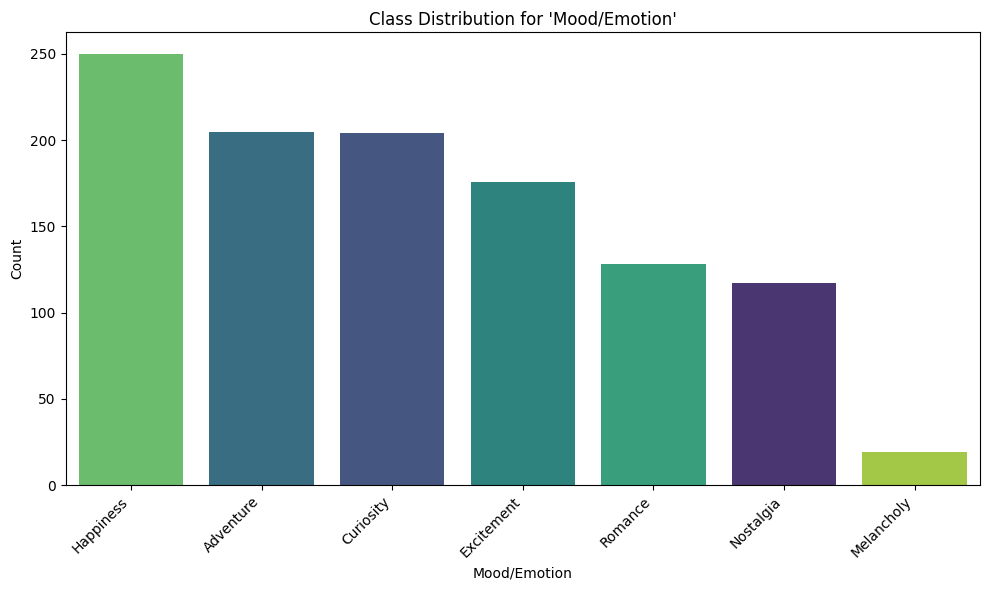

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

for col in categorical_cols:
    plt.figure(figsize=(10, 6))
    sns.countplot(data=df, x=col, order=df[col].value_counts().index, palette='viridis', hue=col, legend=False)
    plt.title(f"Class Distribution for '{col}'")
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

### Explore Relationships between Categorical Features

Investigating potential associations or 'correlations' between different categorical variables using methods like cross-tabulations or contingency tables.


**Understanding trends and correlations**:

To investigate the relationships between categorical features as per the subtask, I will generate cross-tabulations for the specified pairs of columns using `pd.crosstab()` and print each result.



In [ ]:
print("Cross-tabulation: Weather vs. Activity")
print(pd.crosstab(df['Weather'], df['Activity']))
print("\n" + "-"*50 + "\n")

print("Cross-tabulation: Time of Day vs. Activity")
print(pd.crosstab(df['Time of Day'], df['Activity']))
print("\n" + "-"*50 + "\n")

print("Cross-tabulation: Season vs. Activity")
print(pd.crosstab(df['Season'], df['Activity']))
print("\n" + "-"*50 + "\n")

print("Cross-tabulation: Weather vs. Mood/Emotion")
print(pd.crosstab(df['Weather'], df['Mood/Emotion']))
print("\n" + "-"*50 + "\n")

print("Cross-tabulation: Season vs. Mood/Emotion")
print(pd.crosstab(df['Season'], df['Mood/Emotion']))


Cross-tabulation: Weather vs. Activity
Activity   cultural experience  exploring  hiking  relaxing  riding  \
Weather                                                               
Cloudy                       0          4      31        35       1   
Not Clear                    2          5       2         9       0   
Rainy                        0          0       1         2       0   
Snowy                        0          4      18        13       0   
Sunny                        5         30      51       114       4   

Activity   sightseeing  sports  transportation/visiting  unknown  \
Weather                                                            
Cloudy             125       4                        7       19   
Not Clear           57       2                        6       13   
Rainy                9       0                        5        3   
Snowy               39       6                        0       10   
Sunny              331      14                       10

### Summarize Data Characteristics and Insights



### Key Observations
- Strong class imbalance in Mood/Emotion and Activity
- Sightseeing and sunny weather dominate the dataset
- Summer and afternoon are the most common contexts
- Rare classes may negatively impact model performance


## Preprocessing the Description Text

In [ ]:
nltk.download("stopwords")
nltk.download("wordnet")

stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    text = text.lower()                                   # lowercase
    text = re.sub(r'[^a-z\s]', '', text)                 # remove non-letters
    words = text.split()                                 # tokenize
    words = [w for w in words if w not in stop_words]    # remove stopwords
    words = [lemmatizer.lemmatize(w) for w in words]     # lemmatize
    return " ".join(words)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
df["clean_description"] = df["Description"].apply(preprocess_text)
print(df["clean_description"].head())


0    clear image dome rock jerusalem showcasing ico...
1    clear image ibrahimi mosque cave patriarch heb...
2    clear image ancient ruin sebastia near nablus ...
3    clear image mar saba monastery bethlehem built...
4    clear aerial view tell essultan jericho showin...
Name: clean_description, dtype: object


### Feature Extraction

### Option 1: TF-IDF : term frequency and inverse document frequency.

In [ ]:
tfidf = TfidfVectorizer(max_features=6000, ngram_range=(1,1))

X = tfidf.fit_transform(df["clean_description"])


### Option 2: Word Embeddings (better for semantics)

In [ ]:
# embedder = SentenceTransformer('all-MiniLM-L6-v2')

# X = embedder.encode(df["clean_description"], convert_to_numpy=True)
# print(X.shape)
# print(X)


Note : we commented out because option 1 gave us better results but we still tries option 2 to compare

## **Approach for Defining Emotion Classes**

To improve accuracy and compare the effect of different class counts

Two classification settings were explored: the original 7-class Mood/Emotion setup and a feature-engineered 3-class version. The 7-class approach preserves the full emotional detail of the dataset but is more challenging due to strong class imbalance and semantic overlap between emotions. To address this, a 3-class grouping was introduced by merging related emotions into broader categories, ensuring sufficient samples per class. This simplified setting reduces ambiguity and allows more reliable learning, while still capturing meaningful emotional patterns.

### Splitting Dataset

7 Classes

In [ ]:

le = LabelEncoder()
y = le.fit_transform(df[target_col])
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
print("\nEncoded Activity Labels:")
for Class, enc in zip(le.classes_, range(len(le.classes_))):
    print(f"{Class}  -->  {enc}")



Encoded Activity Labels:
Adventure  -->  0
Curiosity  -->  1
Excitement  -->  2
Happiness  -->  3
Melancholy  -->  4
Nostalgia  -->  5
Romance  -->  6


### Encodeing the target column and Oversample minority classes (SMOTE)

Synthetic Minority Over-sampling Technique to fix Imbalances in classes.


In [ ]:
sm = SMOTE()
X_resampled, y_resampled= sm.fit_resample(X_train, y_train)




Trying 3 classes :

 Splitting Dataset

In [ ]:

le = LabelEncoder()
y = le.fit_transform(df[target_col])
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
print("\nEncoded Activity Labels:")
for Class, enc in zip(le.classes_, range(len(le.classes_))):
    print(f"{Class}  -->  {enc}")



Encoded Activity Labels:
Adventure  -->  0
Curiosity  -->  1
Excitement  -->  2
Happiness  -->  3
Melancholy  -->  4
Nostalgia  -->  5
Romance  -->  6


 Oversample minority classes (SMOTE)

Synthetic Minority Over-sampling Technique to fix Imbalances in classes.


In [ ]:
sm = SMOTE()
X_resampled, y_resampled= sm.fit_resample(X_train, y_train)


#Baseline Model: KNN Classifier

---



### **7 Classes**

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knn_1 = KNeighborsClassifier(n_neighbors=1, metric="cosine", weights='distance')
knn_3 = KNeighborsClassifier(n_neighbors=3, metric="cosine", weights='distance')


knn_1.fit(X_resampled, y_resampled)
knn_3.fit(X_resampled, y_resampled)


KNeighborsClassifier(metric='cosine', n_neighbors=3, weights='distance')

In [ ]:
# k = 1
y_pred_1 = knn_1.predict(X_test)
print("KNN (k=1) Accuracy:", accuracy_score(y_test, y_pred_1))
print("\nClassification Report (k=1):")
print(classification_report(y_test, y_pred_1, target_names=le.classes_))

# k = 3
y_pred_3 = knn_3.predict(X_test)
print("KNN (k=3) Accuracy:", accuracy_score(y_test, y_pred_3))
print("\nClassification Report (k=3):")
print(classification_report(y_test, y_pred_3, target_names=le.classes_))



KNN (k=1) Accuracy: 0.41818181818181815

Classification Report (k=1):
              precision    recall  f1-score   support

   Adventure       0.53      0.46      0.49        41
   Curiosity       0.47      0.41      0.44        41
  Excitement       0.44      0.49      0.46        35
   Happiness       0.40      0.40      0.40        50
  Melancholy       0.00      0.00      0.00         4
   Nostalgia       0.18      0.17      0.18        23
     Romance       0.43      0.58      0.49        26

    accuracy                           0.42       220
   macro avg       0.35      0.36      0.35       220
weighted avg       0.42      0.42      0.41       220

KNN (k=3) Accuracy: 0.39545454545454545

Classification Report (k=3):
              precision    recall  f1-score   support

   Adventure       0.49      0.46      0.47        41
   Curiosity       0.50      0.41      0.45        41
  Excitement       0.40      0.49      0.44        35
   Happiness       0.39      0.36      0.38   

<Figure size 600x500 with 0 Axes>

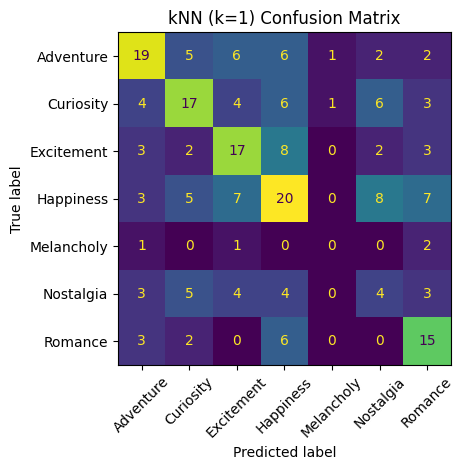

<Figure size 600x500 with 0 Axes>

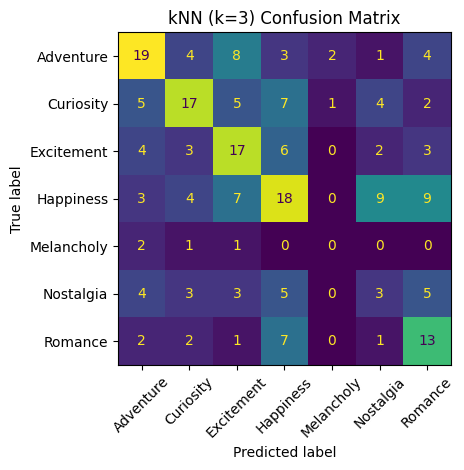

In [ ]:
cm_1 = confusion_matrix(y_test, y_pred_1)
cm_3 = confusion_matrix(y_test, y_pred_3)

plt.figure(figsize=(6, 5))
disp1 = ConfusionMatrixDisplay(confusion_matrix=cm_1, display_labels=le.classes_)
disp1.plot(include_values=True, xticks_rotation=45, colorbar=False)
plt.title("kNN (k=1) Confusion Matrix")
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 5))
disp3 = ConfusionMatrixDisplay(confusion_matrix=cm_3, display_labels=le.classes_)
disp3.plot(include_values=True, xticks_rotation=45, colorbar=False)
plt.title("kNN (k=3) Confusion Matrix")
plt.tight_layout()
plt.show()

In [ ]:

for k in range(1, 11):
    knn = KNeighborsClassifier(n_neighbors=k, metric="cosine")
    knn.fit(X_resampled, y_resampled)
    y_pred = knn.predict(X_test)
    print(f"k={k} Accuracy:", accuracy_score(y_test, y_pred))

k=1 Accuracy: 0.41818181818181815
k=2 Accuracy: 0.41818181818181815
k=3 Accuracy: 0.38636363636363635
k=4 Accuracy: 0.4
k=5 Accuracy: 0.39090909090909093
k=6 Accuracy: 0.38181818181818183
k=7 Accuracy: 0.40454545454545454
k=8 Accuracy: 0.4
k=9 Accuracy: 0.37727272727272726
k=10 Accuracy: 0.37727272727272726


**Hyperparameter Tuning of knn**

In [ ]:
X_tune = df["clean_description"]
le = LabelEncoder()
y_tune = le.fit_transform(df[target_col])

X_tune_train, X_tune_test, y_tune_train, y_tune_test = train_test_split(
    X_tune, y_tune, test_size=0.2, stratify=y_tune, random_state=42
)

print(f"\nEncoded {target_col} Labels:")
for Class, enc in zip(le.classes_, range(len(le.classes_))):
    print(f"{Class}  -->  {enc}")


pipe = ImbPipeline([
    ("tfidf", TfidfVectorizer()),
    ("smote", SMOTE(random_state=42)),  # <-- SMOTE step added
    ("knn", KNeighborsClassifier(algorithm="brute", weights='distance')),
])


param_grid = {
    # TF-IDF parameters
    "tfidf__max_features": [1000, 2000, 4000],
    "tfidf__ngram_range": [(1, 1), (1, 2)],
    "tfidf__min_df": [1, 3],
    "tfidf__max_df": [0.9, 1.0],

    # kNN parameters
    "knn__n_neighbors": [1, 3, 5, 7],
    "knn__metric": ["euclidean", "cosine"],

    # SMOTE parameters
    "smote__k_neighbors": [3, 5, 7],
}

grid = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    cv=5,
    scoring="f1_macro",
    n_jobs=-1,
    verbose=2
)


grid.fit(X_tune_train, y_tune_train)

print("Best CV accuracy:", grid.best_score_)
print("Best hyperparameters:")
for k, v in grid.best_params_.items():
    print(f"  {k}: {v}")

best_model = grid.best_estimator_

y_pred = best_model.predict(X_tune_test)

print("\nTest accuracy:", accuracy_score(y_tune_test, y_pred))
print("\nClassification report on test set:")
print(classification_report(y_tune_test, y_pred, target_names=le.classes_))

# =========================
# 5. Inspect grid results
# =========================
results = pd.DataFrame(grid.cv_results_).sort_values(
    by="mean_test_score", ascending=False
)

print("\nTop 5 configurations:")
cols_to_show = [
    "mean_test_score",
    "param_tfidf__max_features",
    "param_tfidf__ngram_range",
    "param_tfidf__min_df",
    "param_tfidf__max_df",
    "param_knn__n_neighbors",
    "param_knn__metric",
]
print(results[cols_to_show].head(5))


Encoded Mood/Emotion Labels:
Adventure  -->  0
Curiosity  -->  1
Excitement  -->  2
Happiness  -->  3
Melancholy  -->  4
Nostalgia  -->  5
Romance  -->  6
Fitting 5 folds for each of 576 candidates, totalling 2880 fits
Best CV accuracy: 0.3871763547846359
Best hyperparameters:
  knn__metric: cosine
  knn__n_neighbors: 7
  smote__k_neighbors: 5
  tfidf__max_df: 0.9
  tfidf__max_features: 1000
  tfidf__min_df: 1
  tfidf__ngram_range: (1, 1)

Test accuracy: 0.37272727272727274

Classification report on test set:
              precision    recall  f1-score   support

   Adventure       0.51      0.49      0.50        41
   Curiosity       0.48      0.29      0.36        41
  Excitement       0.43      0.43      0.43        35
   Happiness       0.41      0.24      0.30        50
  Melancholy       0.00      0.00      0.00         4
   Nostalgia       0.13      0.17      0.15        23
     Romance       0.35      0.73      0.47        26

    accuracy                           0.37       

### **3 Classes**

**KNN Classifier**

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knn_1 = KNeighborsClassifier(n_neighbors=1, metric="cosine", weights='distance')
knn_3 = KNeighborsClassifier(n_neighbors=3, metric="cosine", weights='distance')


knn_1.fit(X_resampled, y_resampled)
knn_3.fit(X_resampled, y_resampled)


KNeighborsClassifier(metric='cosine', n_neighbors=3, weights='distance')

In [ ]:
# k = 1
y_pred_1 = knn_1.predict(X_test)
print("KNN (k=1) Accuracy:", accuracy_score(y_test, y_pred_1))
print("\nClassification Report (k=1):")
print(classification_report(y_test, y_pred_1, target_names=le.classes_))

# k = 3
y_pred_3 = knn_3.predict(X_test)
print("KNN (k=3) Accuracy:", accuracy_score(y_test, y_pred_3))
print("\nClassification Report (k=3):")
print(classification_report(y_test, y_pred_3, target_names=le.classes_))



KNN (k=1) Accuracy: 0.6409090909090909

Classification Report (k=1):
                 precision    recall  f1-score   support

    Exploratory       0.59      0.54      0.56        82
       Positive       0.71      0.77      0.74       111
calm_reflective       0.44      0.44      0.44        27

       accuracy                           0.64       220
      macro avg       0.58      0.58      0.58       220
   weighted avg       0.64      0.64      0.64       220

KNN (k=3) Accuracy: 0.6181818181818182

Classification Report (k=3):
                 precision    recall  f1-score   support

    Exploratory       0.60      0.55      0.57        82
       Positive       0.77      0.69      0.73       111
calm_reflective       0.31      0.52      0.39        27

       accuracy                           0.62       220
      macro avg       0.56      0.59      0.56       220
   weighted avg       0.65      0.62      0.63       220



<Figure size 600x500 with 0 Axes>

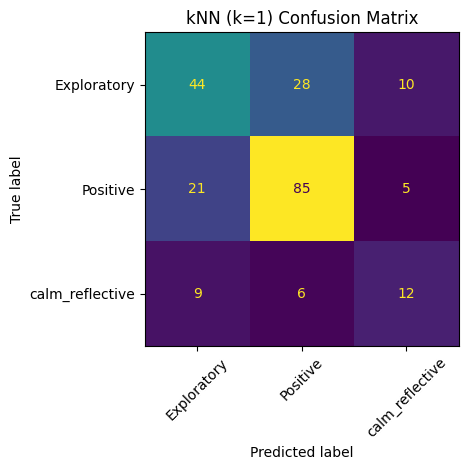

<Figure size 600x500 with 0 Axes>

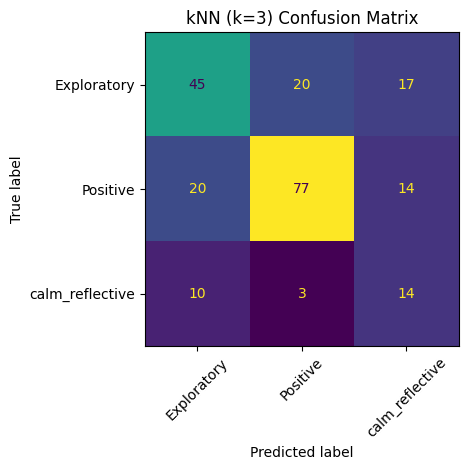

In [ ]:
cm_1 = confusion_matrix(y_test, y_pred_1)
cm_3 = confusion_matrix(y_test, y_pred_3)

plt.figure(figsize=(6, 5))
disp1 = ConfusionMatrixDisplay(confusion_matrix=cm_1, display_labels=le.classes_)
disp1.plot(include_values=True, xticks_rotation=45, colorbar=False)
plt.title("kNN (k=1) Confusion Matrix")
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 5))
disp3 = ConfusionMatrixDisplay(confusion_matrix=cm_3, display_labels=le.classes_)
disp3.plot(include_values=True, xticks_rotation=45, colorbar=False)
plt.title("kNN (k=3) Confusion Matrix")
plt.tight_layout()
plt.show()

In [ ]:

for k in range(1, 11):
    knn = KNeighborsClassifier(n_neighbors=k, metric="cosine")
    knn.fit(X_resampled, y_resampled)
    y_pred = knn.predict(X_test)
    print(f"k={k} Accuracy:", accuracy_score(y_test, y_pred))

k=1 Accuracy: 0.6409090909090909
k=2 Accuracy: 0.6363636363636364
k=3 Accuracy: 0.6181818181818182
k=4 Accuracy: 0.6272727272727273
k=5 Accuracy: 0.6272727272727273
k=6 Accuracy: 0.6136363636363636
k=7 Accuracy: 0.6272727272727273
k=8 Accuracy: 0.6136363636363636
k=9 Accuracy: 0.6090909090909091
k=10 Accuracy: 0.6136363636363636


**Hyperparameter Tuning of knn**

In [ ]:
X_tune = df["clean_description"]
le = LabelEncoder()
y_tune = le.fit_transform(df[target_col])

X_tune_train, X_tune_test, y_tune_train, y_tune_test = train_test_split(
    X_tune, y_tune, test_size=0.2, stratify=y_tune, random_state=42
)

print(f"\nEncoded {target_col} Labels:")
for Class, enc in zip(le.classes_, range(len(le.classes_))):
    print(f"{Class}  -->  {enc}")


pipe = ImbPipeline([
    ("tfidf", TfidfVectorizer()),
    ("smote", SMOTE(random_state=42)),  # <-- SMOTE step added
    ("knn", KNeighborsClassifier(algorithm="brute", weights='distance')),
])


param_grid = {
    # TF-IDF parameters
    "tfidf__max_features": [1000, 2000, 4000],
    "tfidf__ngram_range": [(1, 1), (1, 2)],
    "tfidf__min_df": [1, 3],
    "tfidf__max_df": [0.9, 1.0],

    # kNN parameters
    "knn__n_neighbors": [1, 3, 5, 7],
    "knn__metric": ["euclidean", "cosine"],

    # SMOTE parameters
    "smote__k_neighbors": [3, 5, 7],
}

grid = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    cv=5,
    scoring="accuracy",
    n_jobs=-1,
    verbose=2
)


grid.fit(X_tune_train, y_tune_train)

print("Best CV accuracy:", grid.best_score_)
print("Best hyperparameters:")
for k, v in grid.best_params_.items():
    print(f"  {k}: {v}")

best_model = grid.best_estimator_

y_pred = best_model.predict(X_tune_test)

print("\nTest accuracy:", accuracy_score(y_tune_test, y_pred))
print("\nClassification report on test set:")
print(classification_report(y_tune_test, y_pred, target_names=le.classes_))

# =========================
# 5. Inspect grid results
# =========================
results = pd.DataFrame(grid.cv_results_).sort_values(
    by="mean_test_score", ascending=False
)

print("\nTop 5 configurations:")
cols_to_show = [
    "mean_test_score",
    "param_tfidf__max_features",
    "param_tfidf__ngram_range",
    "param_tfidf__min_df",
    "param_tfidf__max_df",
    "param_knn__n_neighbors",
    "param_knn__metric",
]
print(results[cols_to_show].head(5))


Encoded Mood/Emotion_Engineered Labels:
Exploratory  -->  0
Positive  -->  1
calm_reflective  -->  2
Fitting 5 folds for each of 576 candidates, totalling 2880 fits
Best CV accuracy: 0.6120909090909092
Best hyperparameters:
  knn__metric: cosine
  knn__n_neighbors: 5
  smote__k_neighbors: 5
  tfidf__max_df: 0.9
  tfidf__max_features: 4000
  tfidf__min_df: 1
  tfidf__ngram_range: (1, 1)

Test accuracy: 0.6318181818181818

Classification report on test set:
                 precision    recall  f1-score   support

    Exploratory       0.62      0.59      0.60        82
       Positive       0.82      0.68      0.75       111
calm_reflective       0.30      0.56      0.39        27

       accuracy                           0.63       220
      macro avg       0.58      0.61      0.58       220
   weighted avg       0.68      0.63      0.65       220


Top 5 configurations:
     mean_test_score  param_tfidf__max_features param_tfidf__ngram_range  \
464         0.612091                  

# Proposed Machine Learning Models


---



#1. RNN -Recurrent Neural Network for text calssification


### **7 Classes**

In [ ]:
import tensorflow as tf
import seaborn as sns

In [ ]:
le = LabelEncoder()
y = le.fit_transform(df[target_col].values)          # numeric labels
X = df["clean_description"].astype(str)             # make sure it's string

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print(f"\nEncoded {target_col} Labels:")
for cls, enc in zip(le.classes_, range(len(le.classes_))):
    print(f"{cls}  -->  {enc}")


Encoded Mood/Emotion Labels:
Adventure  -->  0
Curiosity  -->  1
Excitement  -->  2
Happiness  -->  3
Melancholy  -->  4
Nostalgia  -->  5
Romance  -->  6


### Text Vecorization

In [ ]:
encoder = tf.keras.layers.TextVectorization(
    max_tokens=10000,
    output_sequence_length=100   # fixed length for LSTM
)

# X_train is a pandas Series → use .values
encoder.adapt(X_train.values)

vocabulary = np.array(encoder.get_vocabulary())

# Debug: encode / decode one example
original_text = X_train.iloc[0]
encoded_text = encoder(tf.constant([original_text])).numpy()[0]
decoded_text = " ".join(vocabulary[encoded_text])

print("original:", original_text)
print("encoded:", encoded_text)
print("decoded:", decoded_text)

original: swiss alp featuring snowy mountain peak green valley
encoded: [139 195 223  67   6  95  27 124   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0]
decoded: swiss alp featuring snowy mountain peak green valley                                                                                            


### Building the model

Model architecture and Early stopping

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

num_classes = len(le.classes_)

model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(1,), dtype=tf.string),
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=32,
        mask_zero=True
    ),
    tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(16, dropout=0.2, recurrent_dropout=0.2)
    ),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(
        1 if num_classes == 2 else num_classes,
        activation=None if num_classes == 2 else 'softmax'
    )
])



### Compiling the model

In [ ]:
if num_classes == 2:
    # Binary classification
    loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=True)
else:
    # Multi-class classification
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
model.compile(
    loss=loss_fn,
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, 100)               0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, 100, 32)           72704     
                                                                 
 bidirectional (Bidirection  (None, 32)                6272      
 al)                                                             
                                                                 
 dense (Dense)               (None, 16)                528       
                                                                 
 dense_1 (Dense)             (None, 7)                 119       
                                                                 
Total params: 79623 (311.03 KB)
Trainable params: 79623 

### Training

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

class_weight = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_train),
    y=y_train
)

history = model.fit(
    X_train.values,
    y_train,
    epochs=40,       # high, but early stopping will stop earlier
    batch_size=16,
    validation_data=(X_test.values, y_test),
    callbacks=[early_stopping],
    class_weight=dict(enumerate(class_weight))
)

Epoch 1/40
55/55 [==============================] - 22s 212ms/step - loss: 1.9449 - accuracy: 0.1172 - val_loss: 1.9383 - val_accuracy: 0.2591
Epoch 2/40
55/55 [==============================] - 11s 194ms/step - loss: 1.8955 - accuracy: 0.3493 - val_loss: 1.8306 - val_accuracy: 0.3818
Epoch 3/40
55/55 [==============================] - 10s 184ms/step - loss: 1.7105 - accuracy: 0.3914 - val_loss: 1.8105 - val_accuracy: 0.3409
Epoch 4/40
55/55 [==============================] - 10s 172ms/step - loss: 1.4909 - accuracy: 0.5563 - val_loss: 1.8365 - val_accuracy: 0.3955
Epoch 5/40
55/55 [==============================] - 10s 189ms/step - loss: 1.2631 - accuracy: 0.6451 - val_loss: 1.8591 - val_accuracy: 0.4227
Epoch 6/40
55/55 [==============================] - 10s 190ms/step - loss: 1.0905 - accuracy: 0.7099 - val_loss: 1.9101 - val_accuracy: 0.3818
Epoch 7/40
55/55 [==============================] - 10s 191ms/step - loss: 0.9413 - accuracy: 0.7531 - val_loss: 2.1203 - val_accuracy: 0.3955

Evaluation on Training and Validation

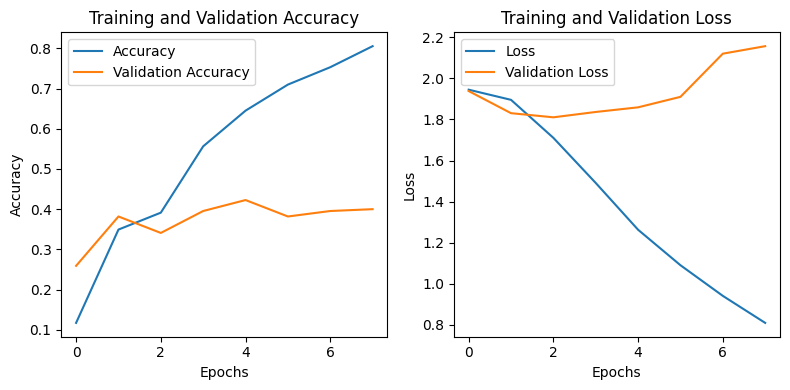

In [ ]:
history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.plot(acc)
plt.plot(val_acc)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Accuracy', 'Validation Accuracy'])

plt.subplot(1, 2, 2)
plt.plot(loss)
plt.plot(val_loss)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Loss', 'Validation Loss'])

plt.tight_layout()
plt.show()


=== Keras Evaluation ===
Train  - Loss: 1.4921, Accuracy: 0.5233
Val    - Loss: 1.8105, Accuracy: 0.3409

=== Classification Report (TRAIN) ===
              precision    recall  f1-score   support

   Adventure       0.68      0.37      0.48       164
   Curiosity       0.47      0.83      0.60       163
  Excitement       0.69      0.13      0.22       141
   Happiness       0.49      0.78      0.60       200
  Melancholy       0.00      0.00      0.00        15
   Nostalgia       0.47      0.50      0.48        94
     Romance       0.77      0.42      0.54       102

    accuracy                           0.52       879
   macro avg       0.51      0.43      0.42       879
weighted avg       0.58      0.52      0.49       879


=== Classification Report (VALIDATION) ===
              precision    recall  f1-score   support

   Adventure       0.36      0.20      0.25        41
   Curiosity       0.36      0.46      0.40        41
  Excitement       0.25      0.03      0.05        

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


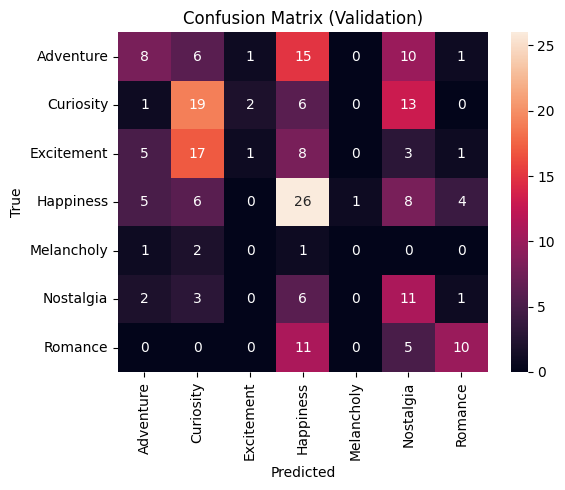

In [ ]:
train_loss, train_acc = model.evaluate(X_train.values, y_train, verbose=0)
val_loss, val_acc = model.evaluate(X_test.values, y_test, verbose=0)

print("\n=== Keras Evaluation ===")
print(f"Train  - Loss: {train_loss:.4f}, Accuracy: {train_acc:.4f}")
print(f"Val    - Loss: {val_loss:.4f}, Accuracy: {val_acc:.4f}")

# -------------------------
# 2. Predictions for detailed metrics
# -------------------------
num_classes = len(le.classes_)

# Get raw outputs from the model
y_train_logits = model.predict(X_train.values, verbose=0)
y_val_logits   = model.predict(X_test.values,  verbose=0)

if num_classes == 2:
    # Binary classification: outputs are logits of shape (N, 1)
    y_train_prob = tf.nn.sigmoid(y_train_logits).numpy().ravel()
    y_val_prob   = tf.nn.sigmoid(y_val_logits).numpy().ravel()

    y_train_pred = (y_train_prob >= 0.5).astype(int)
    y_val_pred   = (y_val_prob   >= 0.5).astype(int)
else:
    # Multi-class: last layer is softmax, so logits are probs of shape (N, C)
    y_train_prob = y_train_logits  # already probabilities
    y_val_prob   = y_val_logits

    y_train_pred = np.argmax(y_train_prob, axis=1)
    y_val_pred   = np.argmax(y_val_prob,   axis=1)

# -------------------------
# 3. Classification report
# -------------------------
print("\n=== Classification Report (TRAIN) ===")
print(classification_report(y_train, y_train_pred, target_names=le.classes_))

print("\n=== Classification Report (VALIDATION) ===")
print(classification_report(y_test, y_val_pred, target_names=le.classes_))

# -------------------------
# 4. Confusion matrix for validation set
# -------------------------
cm = confusion_matrix(y_test, y_val_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=le.classes_,
            yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Validation)')
plt.tight_layout()
plt.show()

### **3 Clases :**

**RNN -Recurrent Neural Network for text calssification**


In [ ]:
import tensorflow as tf
import seaborn as sns

In [ ]:
le = LabelEncoder()
y = le.fit_transform(df[target_col].values)          # numeric labels
X = df["clean_description"].astype(str)             # make sure it's string

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print(f"\nEncoded {target_col} Labels:")
for cls, enc in zip(le.classes_, range(len(le.classes_))):
    print(f"{cls}  -->  {enc}")


Encoded Mood/Emotion_Engineered Labels:
Exploratory  -->  0
Positive  -->  1
calm_reflective  -->  2


### Text Vecorization

In [ ]:
encoder = tf.keras.layers.TextVectorization(
    max_tokens=10000,
    output_sequence_length=100   # fixed length for LSTM
)

# X_train is a pandas Series → use .values
encoder.adapt(X_train.values)

vocabulary = np.array(encoder.get_vocabulary())

# Debug: encode / decode one example
original_text = X_train.iloc[0]
encoded_text = encoder(tf.constant([original_text])).numpy()[0]
decoded_text = " ".join(vocabulary[encoded_text])

print("original:", original_text)
print("encoded:", encoded_text)
print("decoded:", decoded_text)

original: mill middle field river running throw mill best place forget everything connect nature
encoded: [ 952  597  346   75  891 1260  952  543    4 1869 1049 1099   47    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0]
decoded: mill middle field river running throw mill best place forget everything connect nature                                                                                       


### Building the model

Model architecture and Early stopping

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

num_classes = len(le.classes_)

model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(1,), dtype=tf.string),
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=32,
        mask_zero=True
    ),
    tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(16, dropout=0.2, recurrent_dropout=0.2)
    ),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(
        1 if num_classes == 2 else num_classes,
        activation=None if num_classes == 2 else 'softmax'
    )
])



### Compiling the model

In [ ]:
if num_classes == 2:
    # Binary classification
    loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=True)
else:
    # Multi-class classification
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
model.compile(
    loss=loss_fn,
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, 100)               0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, 100, 32)           72192     
                                                                 
 bidirectional (Bidirection  (None, 32)                6272      
 al)                                                             
                                                                 
 dense (Dense)               (None, 16)                528       
                                                                 
 dense_1 (Dense)             (None, 3)                 51        
                                                                 
Total params: 79043 (308.76 KB)
Trainable params: 79043 

### Training

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

class_weight = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_train),
    y=y_train
)

history = model.fit(
    X_train.values,
    y_train,
    epochs=40,       # high, but early stopping will stop earlier
    batch_size=16,
    validation_data=(X_test.values, y_test),
    callbacks=[early_stopping],
    class_weight=dict(enumerate(class_weight))
)

Epoch 1/40
55/55 [==============================] - 19s 212ms/step - loss: 1.0965 - accuracy: 0.2264 - val_loss: 1.0978 - val_accuracy: 0.4136
Epoch 2/40
55/55 [==============================] - 11s 202ms/step - loss: 1.0456 - accuracy: 0.5279 - val_loss: 1.0054 - val_accuracy: 0.5636
Epoch 3/40
55/55 [==============================] - 11s 197ms/step - loss: 0.7695 - accuracy: 0.7042 - val_loss: 0.8788 - val_accuracy: 0.6000
Epoch 4/40
55/55 [==============================] - 11s 196ms/step - loss: 0.4726 - accuracy: 0.8350 - val_loss: 0.9359 - val_accuracy: 0.6227
Epoch 5/40
55/55 [==============================] - 9s 172ms/step - loss: 0.2775 - accuracy: 0.9033 - val_loss: 1.0908 - val_accuracy: 0.5909
Epoch 6/40
55/55 [==============================] - 11s 197ms/step - loss: 0.1796 - accuracy: 0.9443 - val_loss: 1.3355 - val_accuracy: 0.6000
Epoch 7/40
55/55 [==============================] - 11s 197ms/step - loss: 0.1046 - accuracy: 0.9670 - val_loss: 1.5367 - val_accuracy: 0.5682


Evaluation on Training and Validation

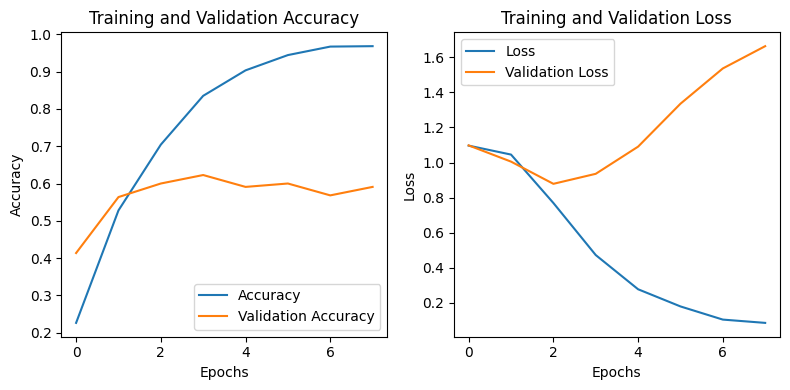

In [ ]:
history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.plot(acc)
plt.plot(val_acc)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Accuracy', 'Validation Accuracy'])

plt.subplot(1, 2, 2)
plt.plot(loss)
plt.plot(val_loss)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Loss', 'Validation Loss'])

plt.tight_layout()
plt.show()


=== Keras Evaluation ===
Train  - Loss: 0.5266, Accuracy: 0.8658
Val    - Loss: 0.8788, Accuracy: 0.6000

=== Classification Report (TRAIN) ===
                 precision    recall  f1-score   support

    Exploratory       0.86      0.83      0.85       327
       Positive       0.90      0.88      0.89       443
calm_reflective       0.77      0.91      0.83       109

       accuracy                           0.87       879
      macro avg       0.84      0.87      0.86       879
   weighted avg       0.87      0.87      0.87       879


=== Classification Report (VALIDATION) ===
                 precision    recall  f1-score   support

    Exploratory       0.54      0.54      0.54        82
       Positive       0.75      0.70      0.73       111
calm_reflective       0.29      0.37      0.32        27

       accuracy                           0.60       220
      macro avg       0.53      0.54      0.53       220
   weighted avg       0.62      0.60      0.61       220



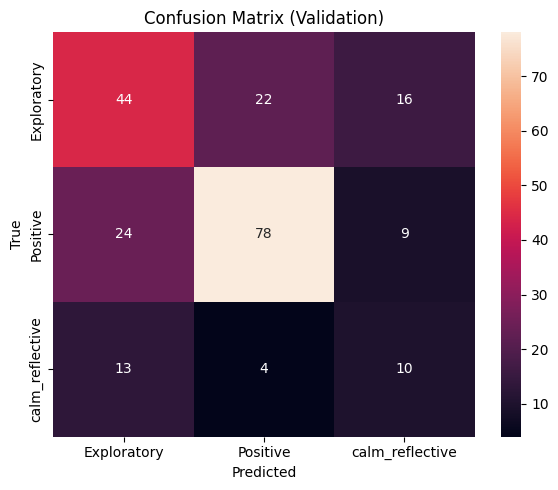

In [ ]:
train_loss, train_acc = model.evaluate(X_train.values, y_train, verbose=0)
val_loss, val_acc = model.evaluate(X_test.values, y_test, verbose=0)

print("\n=== Keras Evaluation ===")
print(f"Train  - Loss: {train_loss:.4f}, Accuracy: {train_acc:.4f}")
print(f"Val    - Loss: {val_loss:.4f}, Accuracy: {val_acc:.4f}")

# -------------------------
# 2. Predictions for detailed metrics
# -------------------------
num_classes = len(le.classes_)

# Get raw outputs from the model
y_train_logits = model.predict(X_train.values, verbose=0)
y_val_logits   = model.predict(X_test.values,  verbose=0)

if num_classes == 2:
    # Binary classification: outputs are logits of shape (N, 1)
    y_train_prob = tf.nn.sigmoid(y_train_logits).numpy().ravel()
    y_val_prob   = tf.nn.sigmoid(y_val_logits).numpy().ravel()

    y_train_pred = (y_train_prob >= 0.5).astype(int)
    y_val_pred   = (y_val_prob   >= 0.5).astype(int)
else:
    # Multi-class: last layer is softmax, so logits are probs of shape (N, C)
    y_train_prob = y_train_logits  # already probabilities
    y_val_prob   = y_val_logits

    y_train_pred = np.argmax(y_train_prob, axis=1)
    y_val_pred   = np.argmax(y_val_prob,   axis=1)

# -------------------------
# 3. Classification report
# -------------------------
print("\n=== Classification Report (TRAIN) ===")
print(classification_report(y_train, y_train_pred, target_names=le.classes_))

print("\n=== Classification Report (VALIDATION) ===")
print(classification_report(y_test, y_val_pred, target_names=le.classes_))

# -------------------------
# 4. Confusion matrix for validation set
# -------------------------
cm = confusion_matrix(y_test, y_val_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=le.classes_,
            yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Validation)')
plt.tight_layout()
plt.show()

## 2. Support Vector Machine (SVMs) :

### **7 Classes**

### Linear SVM :

In [ ]:
from sklearn.svm import LinearSVC
X = df['clean_description']         # text column
y = df[target_col]            # target column

X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


tfidf = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 2),      # unigrams + bigrams for better accuracy
    stop_words="english"
)

X_train_tfidf = tfidf.fit_transform(X_train)
X_val_tfidf   = tfidf.transform(X_val)

sm = SMOTE()
X_resampled, y_resampled= sm.fit_resample(X_train_tfidf, y_train)



model = LinearSVC(class_weight="balanced")
model.fit(X_resampled, y_resampled)

LinearSVC(class_weight='balanced')

Classification Report

In [ ]:
y_pred = model.predict(X_val_tfidf)

print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

   Adventure       0.53      0.68      0.60        41
   Curiosity       0.42      0.39      0.41        41
  Excitement       0.43      0.43      0.43        35
   Happiness       0.48      0.40      0.43        50
  Melancholy       0.00      0.00      0.00         4
   Nostalgia       0.18      0.17      0.18        23
     Romance       0.48      0.54      0.51        26

    accuracy                           0.44       220
   macro avg       0.36      0.37      0.36       220
weighted avg       0.43      0.44      0.43       220



Hyperparameter Tuning for LinearSVC + TF-IDF

In [ ]:
from imblearn.pipeline import Pipeline as ImbPipeline

X = df['clean_description']         # text column
y = df[target_col]            # target column

X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

pipeline = ImbPipeline([
    ("tfidf", TfidfVectorizer(stop_words='english')),
    ("svm", LinearSVC(class_weight="balanced"))
])

param_grid = {
    # -------- TF-IDF params --------
    "tfidf__max_features": [3000, 5000, 8000, None],
    "tfidf__ngram_range": [(1,1), (1,2), (1,3)],
    "tfidf__min_df": [1, 2, 5],
    "tfidf__max_df": [0.9, 0.95, 1.0],

    # -------- Linear SVM params --------
    "svm__C": [0.1, 0.5, 1, 2, 5, 10],
    "svm__loss": ["hinge", "squared_hinge"],
    "svm__tol": [1e-4, 1e-3, 1e-2],
}

grid = GridSearchCV(
    pipeline,
    param_grid,
    scoring="accuracy",    # best for imbalanced multi-class
    cv=5,
    n_jobs=-1,
    verbose=2
)

grid.fit(X_train, y_train)

print("Best params:", grid.best_params_)
print("Best score:", grid.best_score_)

y_pred = grid.predict(X_val)
print(classification_report(y_val, y_pred))

Fitting 5 folds for each of 3888 candidates, totalling 19440 fits
Best params: {'svm__C': 0.1, 'svm__loss': 'squared_hinge', 'svm__tol': 0.0001, 'tfidf__max_df': 0.9, 'tfidf__max_features': None, 'tfidf__min_df': 1, 'tfidf__ngram_range': (1, 2)}
Best score: 0.49826623376623375
              precision    recall  f1-score   support

   Adventure       0.47      0.59      0.52        41
   Curiosity       0.46      0.41      0.44        41
  Excitement       0.45      0.49      0.47        35
   Happiness       0.52      0.48      0.50        50
  Melancholy       0.00      0.00      0.00         4
   Nostalgia       0.29      0.22      0.25        23
     Romance       0.47      0.54      0.50        26

    accuracy                           0.46       220
   macro avg       0.38      0.39      0.38       220
weighted avg       0.45      0.46      0.45       220



### Non-Linear SVM with RBF kernal :

In [ ]:
target_col =  "Mood/Emotion"

X = df["clean_description"]
le = LabelEncoder()
y = le.fit_transform(df[target_col])

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

print(f"\nEncoded labels for {target_col}:")
for cls, enc in zip(le.classes_, range(len(le.classes_))):
    print(f"{cls}  -->  {enc}")


pipe = Pipeline([
    ("tfidf", TfidfVectorizer()),
    ("svm", SVC(kernel="rbf", class_weight="balanced"))  # non-linear SVM
])


param_grid = {
    # TF-IDF
    "tfidf__max_features": [3000, 5000, 8000],
    "tfidf__ngram_range": [(1, 1), (1, 2)],
    "tfidf__min_df": [1, 3],
    "tfidf__max_df": [0.9, 1.0],

    # RBF SVM
    "svm__C": [0.1, 1, 3, 10],
    "svm__gamma": ["scale", "auto", 0.01, 0.001],
}

grid = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    cv=5,
    scoring="f1_macro",   # you can change to "accuracy" if you want
    n_jobs=-1,
    verbose=2
)


grid.fit(X_train, y_train)

print("\nBest CV score (F1 macro):", grid.best_score_)
print("Best hyperparameters:")
for k, v in grid.best_params_.items():
    print(f"  {k}: {v}")

best_model = grid.best_estimator_

y_pred = best_model.predict(X_test)

print("\nTest accuracy:", accuracy_score(y_test, y_pred))
print("Test F1 macro:", f1_score(y_test, y_pred, average="macro"))

print("\nClassification report on test set:")
print(classification_report(y_test, y_pred, target_names=le.classes_))


Encoded labels for Mood/Emotion:
Adventure  -->  0
Curiosity  -->  1
Excitement  -->  2
Happiness  -->  3
Melancholy  -->  4
Nostalgia  -->  5
Romance  -->  6
Fitting 5 folds for each of 384 candidates, totalling 1920 fits

Best CV score (F1 macro): 0.4173064941493611
Best hyperparameters:
  svm__C: 1
  svm__gamma: scale
  tfidf__max_df: 0.9
  tfidf__max_features: 3000
  tfidf__min_df: 1
  tfidf__ngram_range: (1, 1)

Test accuracy: 0.4727272727272727
Test F1 macro: 0.38545365495738804

Classification report on test set:
              precision    recall  f1-score   support

   Adventure       0.47      0.61      0.53        41
   Curiosity       0.42      0.51      0.46        41
  Excitement       0.47      0.46      0.46        35
   Happiness       0.53      0.50      0.52        50
  Melancholy       0.00      0.00      0.00         4
   Nostalgia       0.27      0.13      0.18        23
     Romance       0.56      0.54      0.55        26

    accuracy                           

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## **3 Classes**

## Linear SVM

In [ ]:
from sklearn.svm import LinearSVC
X = df['clean_description']         # text column
y = df[target_col]            # target column

X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


tfidf = TfidfVectorizer(
    max_features=None,
    ngram_range=(1, 3),      # unigrams + bigrams for better accuracy
    stop_words="english",
    min_df=1,
    max_df=1.0
)

X_train_tfidf = tfidf.fit_transform(X_train)
X_val_tfidf   = tfidf.transform(X_val)



model = LinearSVC(
    class_weight="balanced",
    loss="squared_hinge",
    tol=0.01,
    C=0.1
    )
model.fit(X_train_tfidf, y_train)

LinearSVC(C=0.1, class_weight='balanced', tol=0.01)

Classification Report

In [ ]:
y_pred = model.predict(X_val_tfidf)

print(classification_report(y_val, y_pred))

                 precision    recall  f1-score   support

    Exploratory       0.62      0.56      0.59        82
       Positive       0.68      0.84      0.75       111
calm_reflective       0.30      0.11      0.16        27

       accuracy                           0.65       220
      macro avg       0.54      0.50      0.50       220
   weighted avg       0.61      0.65      0.62       220



Hyperparameter Tuning for LinearSVC + TF-IDF

In [ ]:
from imblearn.pipeline import Pipeline as ImbPipeline

X = df['clean_description']         # text column
y = df[target_col]            # target column

X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

pipeline = ImbPipeline([
    ("tfidf", TfidfVectorizer(stop_words='english')),
    ("svm", LinearSVC(class_weight="balanced"))
])

param_grid = {
    # -------- TF-IDF params --------
    "tfidf__max_features": [3000, 5000, 8000, None],
    "tfidf__ngram_range": [(1,1), (1,2), (1,3)],
    "tfidf__min_df": [1, 2, 5],
    "tfidf__max_df": [0.9, 0.95, 1.0],

    # -------- Linear SVM params --------
    "svm__C": [0.1, 0.5, 1, 2, 5, 10],
    "svm__loss": ["hinge", "squared_hinge"],
    "svm__tol": [1e-4, 1e-3, 1e-2],
}

grid = GridSearchCV(
    pipeline,
    param_grid,
    scoring="accuracy",    # best for imbalanced multi-class
    cv=5,
    n_jobs=-1,
    verbose=2
)

grid.fit(X_train, y_train)

print("Best params:", grid.best_params_)
print("Best score:", grid.best_score_)

y_pred = grid.predict(X_val)
print(classification_report(y_val, y_pred))

Fitting 5 folds for each of 3888 candidates, totalling 19440 fits
Best params: {'svm__C': 0.5, 'svm__loss': 'squared_hinge', 'svm__tol': 0.0001, 'tfidf__max_df': 0.9, 'tfidf__max_features': 5000, 'tfidf__min_df': 1, 'tfidf__ngram_range': (1, 2)}
Best score: 0.6541688311688312
                 precision    recall  f1-score   support

    Exploratory       0.61      0.60      0.60        82
       Positive       0.74      0.77      0.76       111
calm_reflective       0.42      0.37      0.39        27

       accuracy                           0.66       220
      macro avg       0.59      0.58      0.58       220
   weighted avg       0.65      0.66      0.66       220



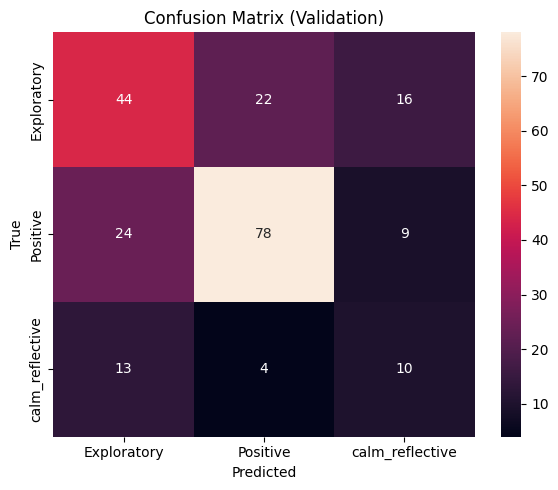

In [ ]:
cm = confusion_matrix(y_test, y_val_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=le.classes_,
            yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Validation)')
plt.tight_layout()
plt.show()

In [ ]:
best_model = grid.best_estimator_

y_pred_best = best_model.predict(X_val)

print(classification_report(y_val, y_pred_best))


                 precision    recall  f1-score   support

    Exploratory       0.61      0.60      0.60        82
       Positive       0.74      0.77      0.76       111
calm_reflective       0.42      0.37      0.39        27

       accuracy                           0.66       220
      macro avg       0.59      0.58      0.58       220
   weighted avg       0.65      0.66      0.66       220



## Non-Linear SVM with RBF kernal

In [ ]:
target_col =  "Mood/Emotion_Engineered"

X = df["clean_description"]
le = LabelEncoder()
y = le.fit_transform(df[target_col])

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

print(f"\nEncoded labels for {target_col}:")
for cls, enc in zip(le.classes_, range(len(le.classes_))):
    print(f"{cls}  -->  {enc}")


pipe = Pipeline([
    ("tfidf", TfidfVectorizer()),
    ("svm", SVC(kernel="rbf", class_weight="balanced"))  # non-linear SVM
])


param_grid = {
    # TF-IDF
    "tfidf__max_features": [3000, 5000, 8000],
    "tfidf__ngram_range": [(1, 1), (1, 2)],
    "tfidf__min_df": [1, 3],
    "tfidf__max_df": [0.9, 1.0],

    # RBF SVM
    "svc__C": [0.5, 1, 2, 5, 10],
    "svc__gamma": ["scale", 0.01, 0.05, 0.1, 0.5]
}

grid = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    cv=5,
    scoring="f1_macro",   # you can change to "accuracy" if you want
    n_jobs=-1,
    verbose=2
)


grid.fit(X_train, y_train)

print("\nBest CV score (F1 macro):", grid.best_score_)
print("Best hyperparameters:")
for k, v in grid.best_params_.items():
    print(f"  {k}: {v}")

best_model = grid.best_estimator_

y_pred = best_model.predict(X_test)

print("\nTest accuracy:", accuracy_score(y_test, y_pred))
print("Test F1 macro:", f1_score(y_test, y_pred, average="macro"))

print("\nClassification report on test set:")
print(classification_report(y_test, y_pred, target_names=le.classes_))


Encoded labels for Mood/Emotion_Engineered:
Exploratory  -->  0
Positive  -->  1
calm_reflective  -->  2
Fitting 5 folds for each of 384 candidates, totalling 1920 fits

Best CV score (F1 macro): 0.5637504990922922
Best hyperparameters:
  svm__C: 10
  svm__gamma: 0.01
  tfidf__max_df: 0.9
  tfidf__max_features: 3000
  tfidf__min_df: 3
  tfidf__ngram_range: (1, 2)

Test accuracy: 0.6545454545454545
Test F1 macro: 0.6035897435897436

Classification report on test set:
                 precision    recall  f1-score   support

    Exploratory       0.60      0.68      0.64        82
       Positive       0.83      0.67      0.74       111
calm_reflective       0.37      0.52      0.43        27

       accuracy                           0.65       220
      macro avg       0.60      0.62      0.60       220
   weighted avg       0.69      0.65      0.66       220



# Performance Analysis of the Best Performing Model


---



### Performance Comparison of Models for 7-Class Mood/Emotion Classification

| Model                            | Accuracy | Macro F1 | Melancholy Recall | Melancholy F1 |
| -------------------------------- | -------- | -------- | ----------------- | ------------- |
| KNN (TF-IDF + SMOTE)             | 0.37     | 0.32     | 0.00              | 0.00          |
| Logistic Regression (balanced)   | 0.46     | 0.39     | 0.00              | 0.00          |
| RNN (TextVectorization)          | 0.45     | 0.42     | 0.50              | 0.22          |
| Naive Bayes (TF-IDF)             | 0.49     | 0.41     | 0.00              | 0.00          |
| Gradient Boosting                | 0.49     | 0.41     | 0.00              | 0.00          |
| Linear SVM (TF-IDF, balanced)    | 0.46     | 0.38     | 0.00              | 0.00          |
| RBF SVM (TF-IDF)                 | 0.47     | 0.39     | 0.00              | 0.00          |
| DistilBERT + BiLSTM (fine-tuned) | 0.42     | 0.36     | 0.00              | 0.00          |
| DistilBERT Embeddings + RBF SVM  | 0.44     | 0.42     | 0.25              | 0.40          |


### Performance Comparison of Models for Feature-Engineered Mood/Emotion Classification (3 Classes)

| Model                                | Accuracy | Macro F1 | calm_reflective Recall | calm_reflective F1 |
| ------------------------------------ | -------- | -------- | ---------------------- | ------------------ |
| KNN (TF-IDF + SMOTE)                 | 0.63     | 0.58     | 0.56                   | 0.39               |
| Logistic Regression (TF-IDF + SMOTE) | 0.63     | 0.58     | 0.52                   | 0.40               |
| RNN (TextVectorization)              | 0.60     | 0.53     | 0.37                   | 0.32               |
| Linear SVM (TF-IDF, balanced)        | 0.66     | 0.58     | 0.37                   | 0.39               |
| RBF SVM (TF-IDF)                     | 0.65     | 0.60     | 0.52                   | 0.43               |
| DistilBERT + BiLSTM (fine-tuned)     | 0.58     | 0.51     | 0.37                   | 0.32               |
| DistilBERT Embeddings + RBF SVM      | 0.63     | 0.56     | 0.37                   | 0.34               |


## Best performing model analysis:

**Best-performing model selection**

Two evaluation settings were studied: the original 7-class Mood/Emotion task and a feature-engineered 3-class version designed to reduce class imbalance.

**7-class task:** The best overall performance in terms of Macro F1 is achieved by the RNN (TextVectorization), the RNN is the only model that shows strong recall for the rare class Melancholy (Recall = 0.50), while most classical models fail completely on that class (Melancholy Recall = 0.00). Therefore, the RNN is considered the best-performing and most balanced model for the 7-class setting.

**3-class task:** The best Macro F1 is achieved by RBF SVM (TF-IDF) with Macro F1 = 0.60 (Accuracy = 0.65). This model is selected as the best model for the feature-engineered setup.

### 1) Error behavior and difficult labels Where misclassifications are concentrated
(7-classes) :

  The 7-class results show a clear pattern: most classical ML models (KNN, Logistic Regression, Naive Bayes, Gradient Boosting, SVMs) achieve moderate accuracy (~0.46–0.49), but they completely fail to predict Melancholy (Recall = 0.00, F1 = 0.00). This strongly suggests that many errors occur when the true label is a rare class, especially Melancholy.

Why Melancholy is difficult

The EDA showed that Melancholy has only 19 samples, making it highly underrepresented. Because of this imbalance, many models learn decision boundaries that prioritize frequent classes and ignore rare ones. As a result, test samples labeled as Melancholy are frequently misclassified into semantically similar majority classes such as:

Nostalgia (both are reflective/low-arousal emotions)

Romance or Happiness (if the text includes positive locations like “sunset”, “beautiful view”, etc.)

Which models handle rare classes better

Unlike the classical models, the RNN achieved Melancholy Recall = 0.50, showing that sequence-based models can capture contextual patterns beyond individual keywords. Similarly, RBF SVM shows improved Melancholy F1 (0.40), indicating that pretrained embeddings may help represent subtle emotion cues even with limited examples.

Conclusion (7-class):
Errors are strongly associated with rare labels and semantic overlap. The dataset imbalance is a primary reason many models do not learn the Melancholy class at all.



(3-class setting) :

When the emotion labels were reduced to three broader categories, Macro F1 increased substantially (up to 0.60 with RBF SVM). This indicates that many errors in the 7-class task were due to fine-grained emotional distinctions that are difficult to infer reliably from short descriptions.

Which class is hardest (calm_reflective)

Even after feature engineering, the minority class (calm_reflective) remains challenging. The best model (RBF SVM) achieves calm_reflective Recall = 0.52 and F1 = 0.43, meaning the model still confuses this class with others.

A likely reason is that calm_reflective language overlaps heavily with other categories:

Calm reflective text often uses neutral scene descriptions (“quiet street”, “walking alone”, “old town”, “view from above”) that could also match nostalgia or even happiness.

Many travel descriptions focus on the scene, not explicitly emotion words, so the emotion label must be inferred indirectly.

Conclusion (3-class):
Reducing classes improves general performance, but reflective/calm moods remain difficult due to indirect cues and overlap with other emotion categories.



### 3) Patterns in mistakes and data-related issues Semantic overlap in labels

A major source of error is that some emotion classes are naturally close in meaning:

Happiness vs Excitement vs Adventure (all can share energetic / positive language)

Nostalgia vs Melancholy (both reflective and can share similar vocabulary)

This makes misclassifications “reasonable” even for humans, especially if the description does not explicitly mention emotions.

Variation in description length and detail

Descriptions vary widely (some short, some long). Short descriptions often lack emotion-specific clues, causing the model to rely on weak signals such as scene keywords (“beach”, “sunset”, “mountain”), which may correlate with multiple emotions. Longer descriptions provide stronger context and generally should be easier to classify.

Class imbalance as a key limitation

The results strongly reflect imbalance effects:

Rare emotions (especially Melancholy) are ignored by most classical models.

Models that can capture deeper representations (RNN / BERT embeddings) perform better on rare classes, but still face limitations due to limited data.

**Summary of insights**

In the 7-class task, most errors are concentrated in rare classes, especially Melancholy, which is underrepresented and semantically close to Nostalgia.

The RNN performed best in the 7-class setting because it achieved the highest Macro F1 while also maintaining meaningful performance on the minority class.

In the 3-class task, overall performance improved significantly, but calm_reflective remains the most difficult class due to indirect language cues and overlap with other emotions.

Many errors are driven by label ambiguity, class imbalance, and large variation in description style and length, which limit the achievable performance.

## **Additional models and trials Implmenation:**


---



### Transfer learning RNN

Pretrained BERT embeddings → BiLSTM classifier (RNN head)

Raw text

   ↓

Tokenizer (IDs + masks)

   ↓

DistilBERT (frozen semantic extractor)

   ↓

BiLSTM (sequence reasoning)

   ↓

Dense layers (decision making)

   ↓

Emotion label

**Text vectorization is separated into three parts:**

* **Classical text  vectorization** ( Bag of words, TF-IDF, n-grams): They represent text as counts or weighted counts of words. problem: no word order, no context capturing, same word will be depicted as always having the same value.

* **Word Embeddings** (Word2Vec, GloVe, FastText): Each word maps to a fixed dense vector. it capture semantic similarity put cannot capture the context.

* **Pretrained feature extractor** (DistilBERT): Produces contextual embeddings, each word's vector depends on surrounding words. DistilBERT output: (batch_size, sequence_length, hidden_dim)
→ (batch, 128, 768).


In [ ]:
!pip -q install -U transformers safetensors


In [ ]:
from transformers import TFAutoModel, AutoTokenizer
from sklearn.utils.class_weight import compute_class_weight

le = LabelEncoder()
y = le.fit_transform(df[target_col].values)          # numeric labels
X = df["clean_description"].astype(str)             # make sure it's string

X_train, X_val, y_train, y_val  = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# class weights (helps your imbalance: calm_reflective is small)
classes = np.unique(y_train)
weights = compute_class_weight(class_weight="balanced", classes=classes, y=y_train)
class_weight = {int(c): float(w) for c, w in zip(classes, weights)}

MODEL_NAME = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
bert = TFAutoModel.from_pretrained(
    MODEL_NAME,
    from_pt=True,          # convert PyTorch weights to TF
    use_safetensors=False  # avoid safetensors bug
)
bert.trainable = False
for layer in bert.layers[-2:]:
    layer.trainable = True

MAX_LEN = 128

def tokenize(texts):
    # IMPORTANT: convert Series -> list[str]
    texts = texts.fillna("").astype(str).tolist() if hasattr(texts, "tolist") else texts
    return tokenizer(
        texts,
        padding="max_length",
        truncation=True,
        max_length=MAX_LEN,
        return_tensors="tf"
    )

train_tokens = tokenize(X_train)
val_tokens   = tokenize(X_val)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/268M [00:00<?, ?B/s]

TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_projector.bias', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.weight']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the mode

In [ ]:
import tensorflow as tf

input_ids = tf.keras.Input(shape=(MAX_LEN,), dtype=tf.int32, name="input_ids")
attention_mask = tf.keras.Input(shape=(MAX_LEN,), dtype=tf.int32, name="attention_mask")

bert_outputs = bert(input_ids, attention_mask=attention_mask)
seq_embeddings = bert_outputs.last_hidden_state  # (batch, seq_len, hidden)

x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=False))(seq_embeddings)
x = tf.keras.layers.Dropout(0.3)(x)
x = tf.keras.layers.Dense(64, activation="relu")(x)
x = tf.keras.layers.Dropout(0.2)(x)
out = tf.keras.layers.Dense(3, activation="softmax")(x)

model = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=out)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)
]

history = model.fit(
    {"input_ids": train_tokens["input_ids"], "attention_mask": train_tokens["attention_mask"]},
    y_train,
    validation_data=(
        {"input_ids": val_tokens["input_ids"], "attention_mask": val_tokens["attention_mask"]},
        y_val
    ),
    epochs=50,
    batch_size=16,
    class_weight=class_weight,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/50
55/55 [==============================] - 592s 10s/step - loss: 1.0911 - accuracy: 0.3333 - val_loss: 1.0638 - val_accuracy: 0.4727
Epoch 2/50
55/55 [==============================] - 370s 7s/step - loss: 1.0648 - accuracy: 0.4334 - val_loss: 1.0281 - val_accuracy: 0.5455
Epoch 3/50
55/55 [==============================] - 380s 7s/step - loss: 1.0569 - accuracy: 0.4778 - val_loss: 1.0270 - val_accuracy: 0.5545
Epoch 4/50
55/55 [==============================] - 353s 6s/step - loss: 1.0266 - accuracy: 0.4960 - val_loss: 0.9932 - val_accuracy: 0.5864
Epoch 5/50
55/55 [==============================] - 394s 7s/step - loss: 1.0038 - accuracy: 0.5631 - val_loss: 0.9794 - val_accuracy: 0.5773
Epoch 6/50
55/55 [==============================] - 371s 7s/step - loss: 1.0004 - accuracy: 0.5233 - val_loss: 0.9692 - val_accuracy: 0.5773
Epoch 7/50
55/55 [==============================] - 356s 7s/step - loss: 0.9868 - accuracy: 0.5324 - val_loss: 0.9419 - val_accuracy: 0.6045
Epoch 8/50
5

                 precision    recall  f1-score   support

    Exploratory     0.5568    0.5976    0.5765        82
       Positive     0.7174    0.5946    0.6502       111
calm_reflective     0.2500    0.3704    0.2985        27

       accuracy                         0.5682       220
      macro avg     0.5081    0.5208    0.5084       220
   weighted avg     0.6002    0.5682    0.5796       220



<Figure size 600x500 with 0 Axes>

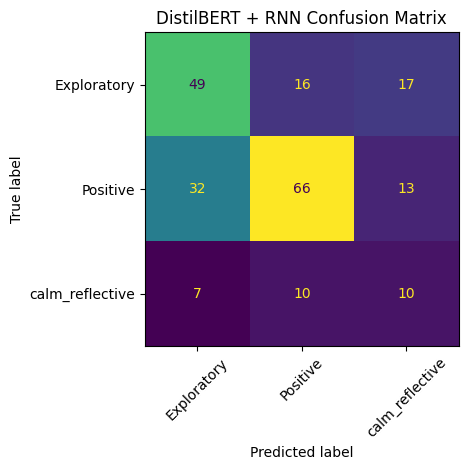

In [ ]:
y_prob = model.predict(
    {"input_ids": val_tokens["input_ids"], "attention_mask": val_tokens["attention_mask"]},
    verbose=0
)
y_pred = np.argmax(y_prob, axis=1)

target_names = le.classes_  # e.g. ['Exploratory','Positive','calm_reflective'] in whatever order LabelEncoder learned
print(classification_report(y_val, y_pred, target_names=target_names, digits=4))

cm = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(6, 5))
disp3 = ConfusionMatrixDisplay(confusion_matrix=cm , display_labels=le.classes_)
disp3.plot(include_values=True, xticks_rotation=45, colorbar=False)
plt.title("DistilBERT + RNN Confusion Matrix")
plt.tight_layout()
plt.show()

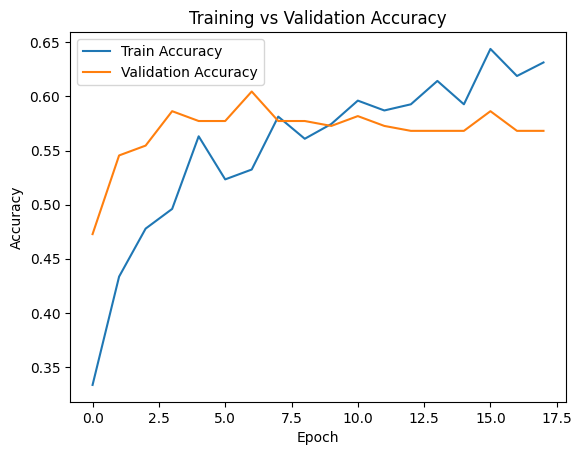

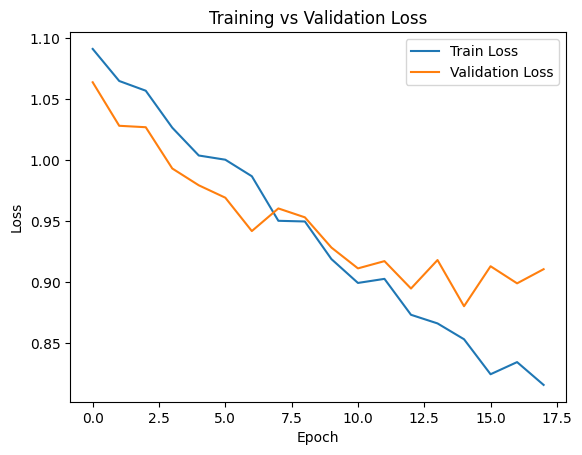

In [ ]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()
plt.show()
plt.figure()
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.show()


In [ ]:
model.save_weights('my_model_weights.weights.h5')
print("Model weights saved to 'my_model_weights.weights.h5'")

/usr/local/lib/python3.12/dist-packages/transformers/generation/tf_utils.py:465: UserWarning: `seed_generator` is deprecated and will be removed in a future version.
  warnings.warn("`seed_generator` is deprecated and will be removed in a future version.", UserWarning)


Model weights saved to 'my_model_weights.weights.h5'


In [ ]:
from google.colab import files

# Ensure the model weights are saved first if not already done
# model.save_weights('my_model_weights.weights.h5')

files.download('my_model_weights.weights.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# DistilBERT + classical classifier ( SVM, Logreg,KNN)

In [ ]:
import numpy as np
import tensorflow as tf

le = LabelEncoder()
y = le.fit_transform(df[target_col].values)          # numeric labels
X = df["clean_description"].astype(str)             # make sure it's string

X_train, X_val, y_train, y_val  = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# class weights (helps your imbalance: calm_reflective is small)
classes = np.unique(y_train)
weights = compute_class_weight(class_weight="balanced", classes=classes, y=y_train)
class_weight = {int(c): float(w) for c, w in zip(classes, weights)}

MODEL_NAME = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
bert = TFAutoModel.from_pretrained(
    MODEL_NAME,
    from_pt=True,          # convert PyTorch weights to TF
    use_safetensors=False  # avoid safetensors bug
)
bert.trainable = False

MAX_LEN = 128

def tokenize(texts):
    # IMPORTANT: convert Series -> list[str]
    texts = texts.fillna("").astype(str).tolist() if hasattr(texts, "tolist") else texts
    return tokenizer(
        texts,
        padding="max_length",
        truncation=True,
        max_length=MAX_LEN,
        return_tensors="tf"
    )

train_tokens = tokenize(X_train)
val_tokens   = tokenize(X_val)

def get_cls_embeddings(tokens, batch_size=64):
    input_ids = tokens["input_ids"]
    attn = tokens["attention_mask"]

    embs = []
    for i in range(0, input_ids.shape[0], batch_size):
        out = bert(
            input_ids[i:i+batch_size],
            attention_mask=attn[i:i+batch_size],
            training=False
        ).last_hidden_state  # (B, seq, 768)

        cls = out[:, 0, :]   # take first token representation -> (B, 768)
        embs.append(cls.numpy())

    return np.vstack(embs)

Xtr_emb = get_cls_embeddings(train_tokens)
Xva_emb = get_cls_embeddings(val_tokens)


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_projector.bias', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.weight']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [ ]:
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# RBF SVM usually benefits from scaling
rbf_svm = Pipeline([
    ("scaler", StandardScaler()),
    ("svm", SVC(kernel="rbf", class_weight="balanced"))
])

rbf_svm.fit(Xtr_emb, y_train)
pred = rbf_svm.predict(Xva_emb)

print(classification_report(y_val, pred, target_names=le.classes_, digits=4))


# Linear SVM (often strong on BERT embeddings)
lin_svm = Pipeline([
    ("scaler", StandardScaler()),
    ("svm", LinearSVC(class_weight="balanced"))
])

lin_svm.fit(Xtr_emb, y_train)
pred2 = lin_svm.predict(Xva_emb)

print(classification_report(y_val, pred2, target_names=le.classes_, digits=4))


                 precision    recall  f1-score   support

    Exploratory     0.5465    0.5732    0.5595        82
       Positive     0.7212    0.6757    0.6977       111
calm_reflective     0.3667    0.4074    0.3860        27

       accuracy                         0.6045       220
      macro avg     0.5448    0.5521    0.5477       220
   weighted avg     0.6126    0.6045    0.6079       220

                 precision    recall  f1-score   support

    Exploratory     0.4937    0.4756    0.4845        82
       Positive     0.5966    0.6396    0.6174       111
calm_reflective     0.2727    0.2222    0.2449        27

       accuracy                         0.5273       220
      macro avg     0.4543    0.4458    0.4489       220
   weighted avg     0.5185    0.5273    0.5221       220



/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [ ]:
def mean_pool(last_hidden_state, attention_mask):
    mask = tf.cast(tf.expand_dims(attention_mask, -1), tf.float32)  # (B, L, 1)
    summed = tf.reduce_sum(last_hidden_state * mask, axis=1)        # (B, H)
    counts = tf.reduce_sum(mask, axis=1) + 1e-9                     # (B, 1)
    return summed / counts                                          # (B, H)

def get_bert_embeddings(tokens, bert, batch_size=64):
    input_ids = tokens["input_ids"]
    attn = tokens["attention_mask"]
    embs = []

    for i in range(0, input_ids.shape[0], batch_size):
        out = bert(
            input_ids[i:i+batch_size],
            attention_mask=attn[i:i+batch_size],
            training=False
        ).last_hidden_state  # (B, L, H)

        pooled = mean_pool(out, attn[i:i+batch_size])  # (B, H)
        embs.append(pooled.numpy())

    return np.vstack(embs)

Xtr_emb = get_bert_embeddings(train_tokens, bert, batch_size=64)
Xva_emb = get_bert_embeddings(val_tokens, bert, batch_size=64)


In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, StratifiedKFold

pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("svm", SVC(kernel="rbf", class_weight="balanced"))
])

param_grid = {
    "svm__C":     [0.1, 0.5, 1, 2, 5, 10, 20, 50],
    "svm__gamma": ["scale", "auto", 1e-4, 5e-4, 1e-3, 5e-3, 1e-2, 5e-2, 1e-1]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid = GridSearchCV(
    pipe,
    param_grid=param_grid,
    scoring="f1_macro",
    cv=cv,
    n_jobs=-1,
    verbose=1
)

grid.fit(Xtr_emb, y_train)

print("Best params:", grid.best_params_)
print("Best CV macro F1:", grid.best_score_)
best_model = grid.best_estimator_

from sklearn.metrics import classification_report, confusion_matrix

y_pred = best_model.predict(Xva_emb)
print(classification_report(y_val, y_pred, target_names=le.classes_, digits=4))

cm = confusion_matrix(y_val, y_pred)
print("Confusion matrix:\n", cm)



Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best params: {'svm__C': 1, 'svm__gamma': 'scale'}
Best CV macro F1: 0.5847414680640743
                 precision    recall  f1-score   support

    Exploratory     0.6071    0.6220    0.6145        82
       Positive     0.7429    0.7027    0.7222       111
calm_reflective     0.3226    0.3704    0.3448        27

       accuracy                         0.6318       220
      macro avg     0.5575    0.5650    0.5605       220
   weighted avg     0.6407    0.6318    0.6357       220

Confusion matrix:
 [[51 20 11]
 [23 78 10]
 [10  7 10]]


## Logistic Regression

7 classes

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to co

Logistic Regression accuracy: 0.4681818181818182

Classification Report:
              precision    recall  f1-score   support

   Adventure       0.45      0.66      0.53        41
   Curiosity       0.48      0.39      0.43        41
  Excitement       0.44      0.46      0.45        35
   Happiness       0.58      0.38      0.46        50
  Melancholy       0.00      0.00      0.00         4
   Nostalgia       0.33      0.39      0.36        23
     Romance       0.52      0.62      0.56        26

    accuracy                           0.47       220
   macro avg       0.40      0.41      0.40       220
weighted avg       0.47      0.47      0.46       220



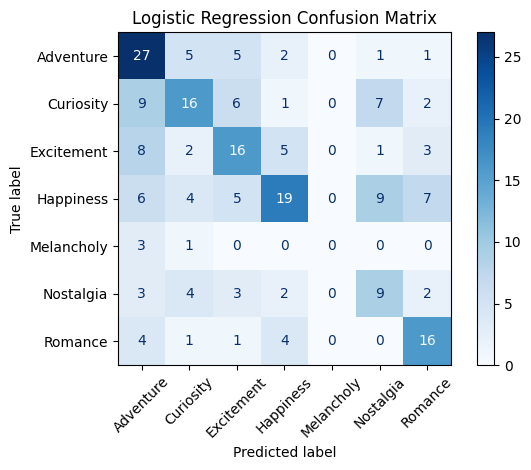

In [ ]:
logreg = LogisticRegression(
    multi_class="auto",
    penalty="l2",
    C=1,
    solver="saga",
    max_iter=10000,
    class_weight='balanced'
)

logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)

print("Logistic Regression accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(xticks_rotation=45, cmap="Blues")
plt.title("Logistic Regression Confusion Matrix")
plt.tight_layout()
plt.show()

### Hyperparameters Tuning of logistic regression

In [ ]:
X_tune = df["clean_description"]
le = LabelEncoder()
y_tune = le.fit_transform(df[target_col])

X_tune_train, X_tune_test, y_tune_train, y_tune_test = train_test_split(
    X_tune, y_tune, test_size=0.2, stratify=y_tune, random_state=42
)

pipe = Pipeline([
    ("tfidf", TfidfVectorizer()),
    ("logreg", LogisticRegression(class_weight='balanced'))
])

param_grid = {
    "tfidf__max_features": [2000, 4000, 6000],
    "tfidf__ngram_range": [(1,1), (1,2)],
    "logreg__C": [0.1, 1, 5, 10],
    "logreg__penalty": ["l2"],
    "logreg__solver": ["lbfgs", "saga"],
    "logreg__max_iter": [300, 500]
}

grid = GridSearchCV(
    pipe,
    param_grid,
    scoring="f1_macro",
    cv=5,
    n_jobs=-1,
    verbose=2
)

grid.fit(X_tune_train, y_tune_train)

print("Best params:", grid.best_params_)
print("Best CV f1_macro:", grid.best_score_)

Fitting 5 folds for each of 96 candidates, totalling 480 fits
Best params: {'logreg__C': 1, 'logreg__max_iter': 300, 'logreg__penalty': 'l2', 'logreg__solver': 'saga', 'tfidf__max_features': 6000, 'tfidf__ngram_range': (1, 2)}
Best CV f1_macro: 0.42334163145197296


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


### Hyperparameters Tuning of logistic regression

In [ ]:
X_tune = df["clean_description"]
le = LabelEncoder()
y_tune = le.fit_transform(df[target_col])

X_tune_train, X_tune_test, y_tune_train, y_tune_test = train_test_split(
    X_tune, y_tune, test_size=0.2, stratify=y_tune, random_state=42
)

pipe = Pipeline([
    ("tfidf", TfidfVectorizer()),
    ("logreg", LogisticRegression(class_weight='balanced'))
])

param_grid = {
    "tfidf__max_features": [2000, 4000, 6000],
    "tfidf__ngram_range": [(1,1), (1,2)],
    "logreg__C": [0.1, 1, 5, 10],
    "logreg__penalty": ["l2"],
    "logreg__solver": ["lbfgs", "saga"],
    "logreg__max_iter": [300, 500]
}

grid = GridSearchCV(
    pipe,
    param_grid,
    scoring="f1_macro",
    cv=5,
    n_jobs=-1,
    verbose=2
)

grid.fit(X_tune_train, y_tune_train)

print("Best params:", grid.best_params_)
print("Best CV f1_macro:", grid.best_score_)

Fitting 5 folds for each of 96 candidates, totalling 480 fits
Best params: {'logreg__C': 1, 'logreg__max_iter': 300, 'logreg__penalty': 'l2', 'logreg__solver': 'lbfgs', 'tfidf__max_features': 4000, 'tfidf__ngram_range': (1, 2)}
Best CV f1_macro: 0.42333638931222667


3 Classes :

### Logistic Regression

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Logistic Regression accuracy: 0.4772727272727273

Classification Report:
              precision    recall  f1-score   support

   Adventure       0.46      0.63      0.54        41
   Curiosity       0.52      0.41      0.46        41
  Excitement       0.46      0.49      0.47        35
   Happiness       0.59      0.40      0.48        50
  Melancholy       0.00      0.00      0.00         4
   Nostalgia       0.33      0.35      0.34        23
     Romance       0.52      0.65      0.58        26

    accuracy                           0.48       220
   macro avg       0.41      0.42      0.41       220
weighted avg       0.49      0.48      0.47       220



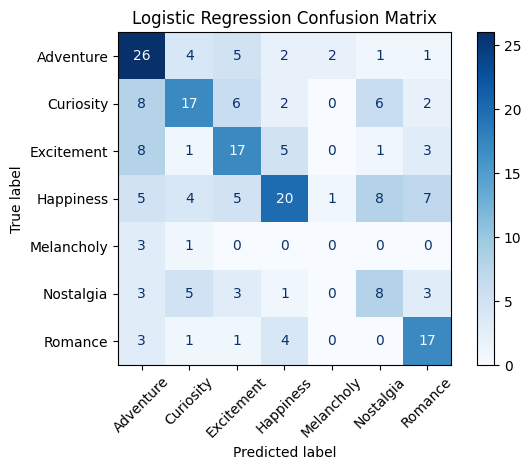

In [ ]:
logreg = LogisticRegression(
    multi_class="auto",
    penalty="l2",
    C=1,
    solver="saga",
    max_iter=10000,
    class_weight='balanced'
)

logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)

print("Logistic Regression accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(xticks_rotation=45, cmap="Blues")
plt.title("Logistic Regression Confusion Matrix")
plt.tight_layout()
plt.show()

## Hyperparameters Tuning of logistic regression

In [ ]:
X_tune = df["clean_description"]
le = LabelEncoder()
y_tune = le.fit_transform(df[target_col])

X_tune_train, X_tune_test, y_tune_train, y_tune_test = train_test_split(
    X_tune, y_tune, test_size=0.2, stratify=y_tune, random_state=42
)

pipe = Pipeline([
    ("tfidf", TfidfVectorizer()),
    ("logreg", LogisticRegression(class_weight='balanced'))
])

param_grid = {
    "tfidf__max_features": [2000, 4000, 6000],
    "tfidf__ngram_range": [(1,1), (1,2)],
    "logreg__C": [0.1, 1, 5, 10],
    "logreg__penalty": ["l2"],
    "logreg__solver": ["lbfgs", "saga"],
    "logreg__max_iter": [300, 500]
}

grid = GridSearchCV(
    pipe,
    param_grid,
    scoring="f1_macro",
    cv=5,
    n_jobs=-1,
    verbose=2
)

grid.fit(X_tune_train, y_tune_train)

print("Best params:", grid.best_params_)
print("Best CV f1_macro:", grid.best_score_)
best_model = grid.best_estimator_
y_pred = best_model.predict(X_tune_test)
print(classification_report(y_tune_test, y_pred, target_names=le.classes_))

Fitting 5 folds for each of 96 candidates, totalling 480 fits
Best params: {'logreg__C': 1, 'logreg__max_iter': 300, 'logreg__penalty': 'l2', 'logreg__solver': 'lbfgs', 'tfidf__max_features': 4000, 'tfidf__ngram_range': (1, 2)}
Best CV f1_macro: 0.42333638931222667
              precision    recall  f1-score   support

   Adventure       0.46      0.59      0.52        41
   Curiosity       0.55      0.44      0.49        41
  Excitement       0.39      0.43      0.41        35
   Happiness       0.54      0.44      0.48        50
  Melancholy       0.00      0.00      0.00         4
   Nostalgia       0.28      0.30      0.29        23
     Romance       0.52      0.58      0.55        26

    accuracy                           0.46       220
   macro avg       0.39      0.40      0.39       220
weighted avg       0.46      0.46      0.46       220

